#### <font color="asparagus"> $\Rightarrow$ Advanced Regression: House price prediction: <br> <font>
$\Rightarrow$ The objective here is to find the key features/indicators that will help a US-based housing company decide whether they should buy a house and then flip them for profit.<br>
$\Rightarrow$ We will build a regression model using regularization in order to predict the actual value of the prospective properties and decide whether to invest in them or not. <br> 
$\Rightarrow$ The entire analysis can be split into the following sections:

### <font color='cyan'> Sections in this notebook: <font>
I. Prerequisites 
    
    I.1. Importing modules, load data
    I.2. Getting rid of certain columns
    I.3. Quasi-Constant Variables

II. Data Analysis 

    II.1.1. Univariate Analysis
    II.1.2. Bivariate Analysis
    II.1.3 Correlation

III. Handling categorical data
    
    
IV. Model building
    
    IV.1 Train test split
    IV.2 Basic Linear Regression
    IV.3 RFE
    IV.4 Some manual elimination based on p values of statsmodels' summary stats
    
V. Ridge and Lasso Regression 
    
    V.1 Ridge 
    V.2 Lasso
    
VI. Comparison and Extras
    
VII. Ridge and Lasso Regression on top of RFE
    
    VII.1 Ridge
    VII.2 Lasso

VIII. Assignment questions

# <font color='goldenrod'> I. Prerequisites </font>

### <font color='skyblue'>  I.1. Importing modules, load data<font>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from sklearn.feature_selection import VarianceThreshold

In [4]:
from sklearn.preprocessing import scale, MinMaxScaler

In [5]:
from sklearn.feature_selection import RFE

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
df = pd.read_csv("train.csv")

In [8]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
nRows, nCols = df.shape

In [10]:
nRows, nCols

(1460, 81)

### <font color='skyblue'>  I.2 Getting rid of certain columns <font>

#### <font color="asparagus"> I.2.1  Checking for NaNs and getting rid of columns with too many NaNs <font>

In [11]:
naDict = {}
for col in df.columns:
    if df[col].isna().sum() > 0:
        naDict[col] = [df[col].isna().sum(), round(100 *(df[col].isna().sum()/nRows),2)]

In [12]:
naDict

{'LotFrontage': [259, 17.74],
 'Alley': [1369, 93.77],
 'MasVnrType': [8, 0.55],
 'MasVnrArea': [8, 0.55],
 'BsmtQual': [37, 2.53],
 'BsmtCond': [37, 2.53],
 'BsmtExposure': [38, 2.6],
 'BsmtFinType1': [37, 2.53],
 'BsmtFinType2': [38, 2.6],
 'Electrical': [1, 0.07],
 'FireplaceQu': [690, 47.26],
 'GarageType': [81, 5.55],
 'GarageYrBlt': [81, 5.55],
 'GarageFinish': [81, 5.55],
 'GarageQual': [81, 5.55],
 'GarageCond': [81, 5.55],
 'PoolQC': [1453, 99.52],
 'Fence': [1179, 80.75],
 'MiscFeature': [1406, 96.3]}

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ *Alley*, *PoolQC*, *Fence*, *MiscFeature* have a lot of missing values. Even *FireplaceQu* has around 47% missing values.<br> 
$\Rightarrow$ It doesn't make sense to keep them by imputing the values. Best to drop these columns

In [13]:
droppedCols = []

In [14]:
droppedCols.extend(["Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu"])

Columns to drop:

In [15]:
droppedCols

['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']

##### <font color="asparagus"> $\Rightarrow$ *id:* </font> <br> This column doesn't add any new information, we can drop this too

In [16]:
droppedCols.append("Id")

##### <font color="asparagus"> $\Rightarrow$ *Dropping columns accumulated so far*<font>

#### <font color="asparagus"> I.2.2  Imputing missing values of the remaining columns because the percentage of missing values is less<font>

In [17]:
for entry in droppedCols:
    if entry in naDict.keys():
        del naDict[entry]

In [18]:
naDict

{'LotFrontage': [259, 17.74],
 'MasVnrType': [8, 0.55],
 'MasVnrArea': [8, 0.55],
 'BsmtQual': [37, 2.53],
 'BsmtCond': [37, 2.53],
 'BsmtExposure': [38, 2.6],
 'BsmtFinType1': [37, 2.53],
 'BsmtFinType2': [38, 2.6],
 'Electrical': [1, 0.07],
 'GarageType': [81, 5.55],
 'GarageYrBlt': [81, 5.55],
 'GarageFinish': [81, 5.55],
 'GarageQual': [81, 5.55],
 'GarageCond': [81, 5.55]}

In [19]:
for entry in naDict.keys():
    df[entry] = df[entry].fillna(df[entry].mode()[0])

##### <font color="asparagus"> $\Rightarrow$ *We will drop the columns once a little more analysis is complete:*<font>

### <font color='skyblue'>  I.3. Quasi-Constant Variables <font>

In [20]:
df_numeric = df.select_dtypes(include=np.number)

In [21]:
sel = VarianceThreshold(threshold=0.05)

sel.fit(df_numeric.iloc[:,:])


VarianceThreshold(threshold=0.05)

In [22]:
quasi_constant_features_list = [x for x in df_numeric.columns if x not in df_numeric.columns[sel.get_support()]]


In [23]:
quasi_constant_features_list

['KitchenAbvGr']

##### <font color="asparagus"> $\Rightarrow$ *KitchenAbvGr seems to have the same value for > 95% of the rows*<font>

In [24]:
droppedCols.append("KitchenAbvGr")

In [25]:
df_cached = df.copy()

# <font color='goldenrod'> II. Data Analysis </font>

"Neighborhood" and "Exterior2nd" have way too many categories. After looking at the value counts, I decided to club certain values as "Other" for easier analysis. Note: The number of rows were also quite low (<1%)

In [26]:
convertMeListNeigh = ["StoneBr", "SWISU", "MeadowV", "Blmngtn", "BrDale", "Veenker", "NPkVill", "Blueste"]
def convert_to_others_neighborhood(value):
    if value in convertMeListNeigh:
        return "Other"
    else:
        return value
df.Neighborhood = df.Neighborhood.apply(convert_to_others_neighborhood)

In [27]:
convertMeList = ["Stucco", "BrkFace", "AsbShng", "ImStucc", "Brk Cmn", "Stone", "AsphShn", "CBlock"]
def convert_to_others(value):
    if value in convertMeList:
        return "Other"
    else:
        return value
df.Exterior2nd = df.Exterior2nd.apply(convert_to_others)

### <font color='skyblue'>  II.1.1. Univariate Analysis <font>
    Need to see if the data distribution is good. Earlier we checked for quasi-constant features on numeric data. Let's confirm the same on the others. Ideally, we want to retain only those columns that have no skews.

In [28]:
df_numeric = df.select_dtypes(include=np.number)

In [29]:
cont_cols = list(df_numeric.columns)

In [30]:
df_numeric.drop("MSSubClass", axis=1, inplace=True) # Though a number, it is a category

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
cat_cols = [col for col in df.columns if col not in df_numeric.columns]

In [32]:
thr = 95

In [33]:
quasi_constant_cat_cols = []

In [34]:
for col in cat_cols:
    mode_pct = (round(((len(df[df[col] == df[col].mode()[0]]))/df.shape[0])*100, 2))
    if mode_pct > thr:
        quasi_constant_cat_cols.append(col)
        print(col)
        print("pct: ", mode_pct)

Street
pct:  99.59
Utilities
pct:  99.93
Condition2
pct:  98.97
RoofMatl
pct:  98.22
Heating
pct:  97.81
GarageQual
pct:  95.34
GarageCond
pct:  96.37


#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ I think we can drop these columns before model deployment since the model won't really learn much from them. But it's good to have for EDA. 

### <font color='skyblue'>  II.1.2. Bivariate Analysis </font>

In [35]:
df.drop(droppedCols, axis=1, inplace=True)

In [36]:
df_numeric = df.select_dtypes(include=np.number)

In [37]:
cont_cols = list(df_numeric.columns)

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ For ease of visiblity, let's analyze "SalePrice" vs columns with <=10 categories

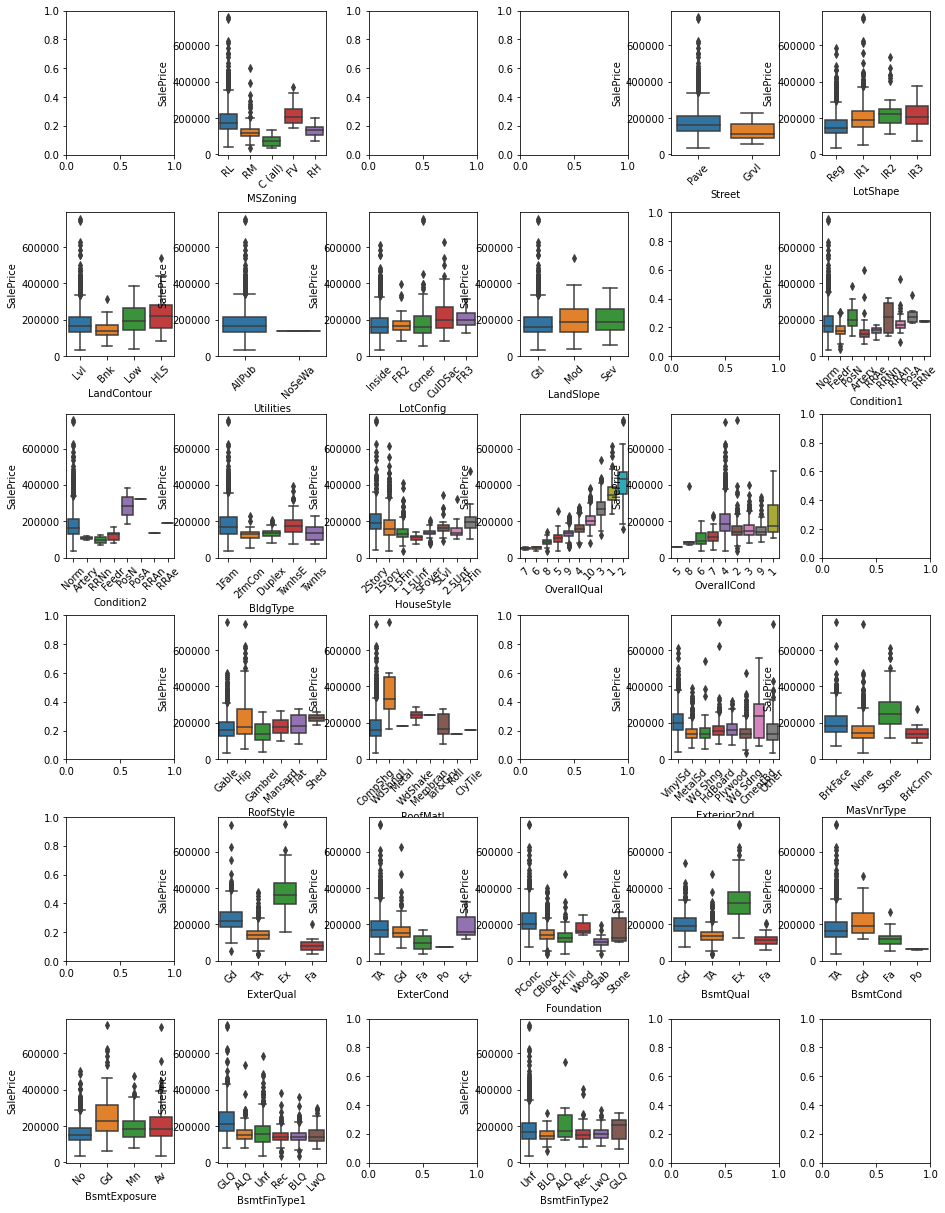

In [38]:
fig, axes = plt.subplots(6,6, figsize=(15,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for col, ax in zip(df.columns, axes.flatten()):
    if df[col].nunique() <= 10:
        sns.boxplot(y="SalePrice", x=col, data=df, orient='v', ax=ax)
        ax.set_xticklabels(df[col].unique(), rotation=45,color="black")
plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font><br>
#### I am restricting to variables that might give us some insight about the data. If it is not revealing a lot, I will skip it in the comments below. Also some columns have less(or none) data of a certain category.
    
$\Rightarrow$ <font color="asparagus"> MSZoning: <font>
    
Commercial properties seem to have the lowest sale price. While FV(Floating village residential) has the higest sale price
    
$\Rightarrow$ <font color="asparagus"> Street: <font>
    
Properties with paved streets have higher sale price compared to properties with graveled pathways

$\Rightarrow$ <font color="asparagus"> Lot Shape: <font>
    
Banked contours have the lowest price. Near Flat/Level has quite a lot of outliers and HLS(hillside) properties have the highest price.

$\Rightarrow$ <font color="asparagus"> Land Contour: <font>
    
Employees with an experience of around 4 years seem to successfully pay off their loans, whereas the defaulters seem to have close to 5 years of experience. Currently running loans have more than 7 years of experience.

$\Rightarrow$ <font color="asparagus"> Condition1: </font>
    
RRNn(Within 200' of North-South Railroad) properities' prices seem to have the higest spread 

$\Rightarrow$ <font color="asparagus"> Condition2: <font>
    
PosN(Near positive off-site feature--park, greenbelt, etc.) have the highest price by far
    
$\Rightarrow$ <font color="asparagus"> OverallQual: <font>
    
Strangely, the price of poor(2) properties is the higest, whereas very excellent(10) has the fourth highest after 1 and 3.      

$\Rightarrow$ <font color="asparagus"> OverallCond: <font>
    
Here below average(4) has a lot of outliers on the upper side and 1(poor) condition properties have the highest price after excellent condition properties(9).
    

$\Rightarrow$ <font color="asparagus"> RoofMatl: <font>
    
Properties using Wood Shingles have the highest prices.

$\Rightarrow$ <font color="asparagus"> MasVnrType: <font>

Common brick and none masonry veneers have the lowest prices while stone masonry veneers have the highest price.
 
$\Rightarrow$ <font color="asparagus"> ExterQual: <font>
    
As expected, excellent quality exteriors go for more whereas Fair has the lowest price.
    
$\Rightarrow$ <font color="asparagus"> ExterCond: <font>
    
As expected, excellent condition exteriors go for more whereas Poor has the lowest price.
    
$\Rightarrow$ <font color="asparagus"> BsmntQual: <font>
    
As expected, excellent quality basement go for more whereas Fair has the lowest price.
    
$\Rightarrow$ <font color="asparagus"> BsmntExposure: <font>
    
Basements with good exposure have a higher price.
    

### <font color='skyblue'>  II.1.3 Correlation <font>

#### <font color="asparagus"> *Need to create a heatmap of all the retained numeric variables and check the relationship* <font>

In [39]:
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

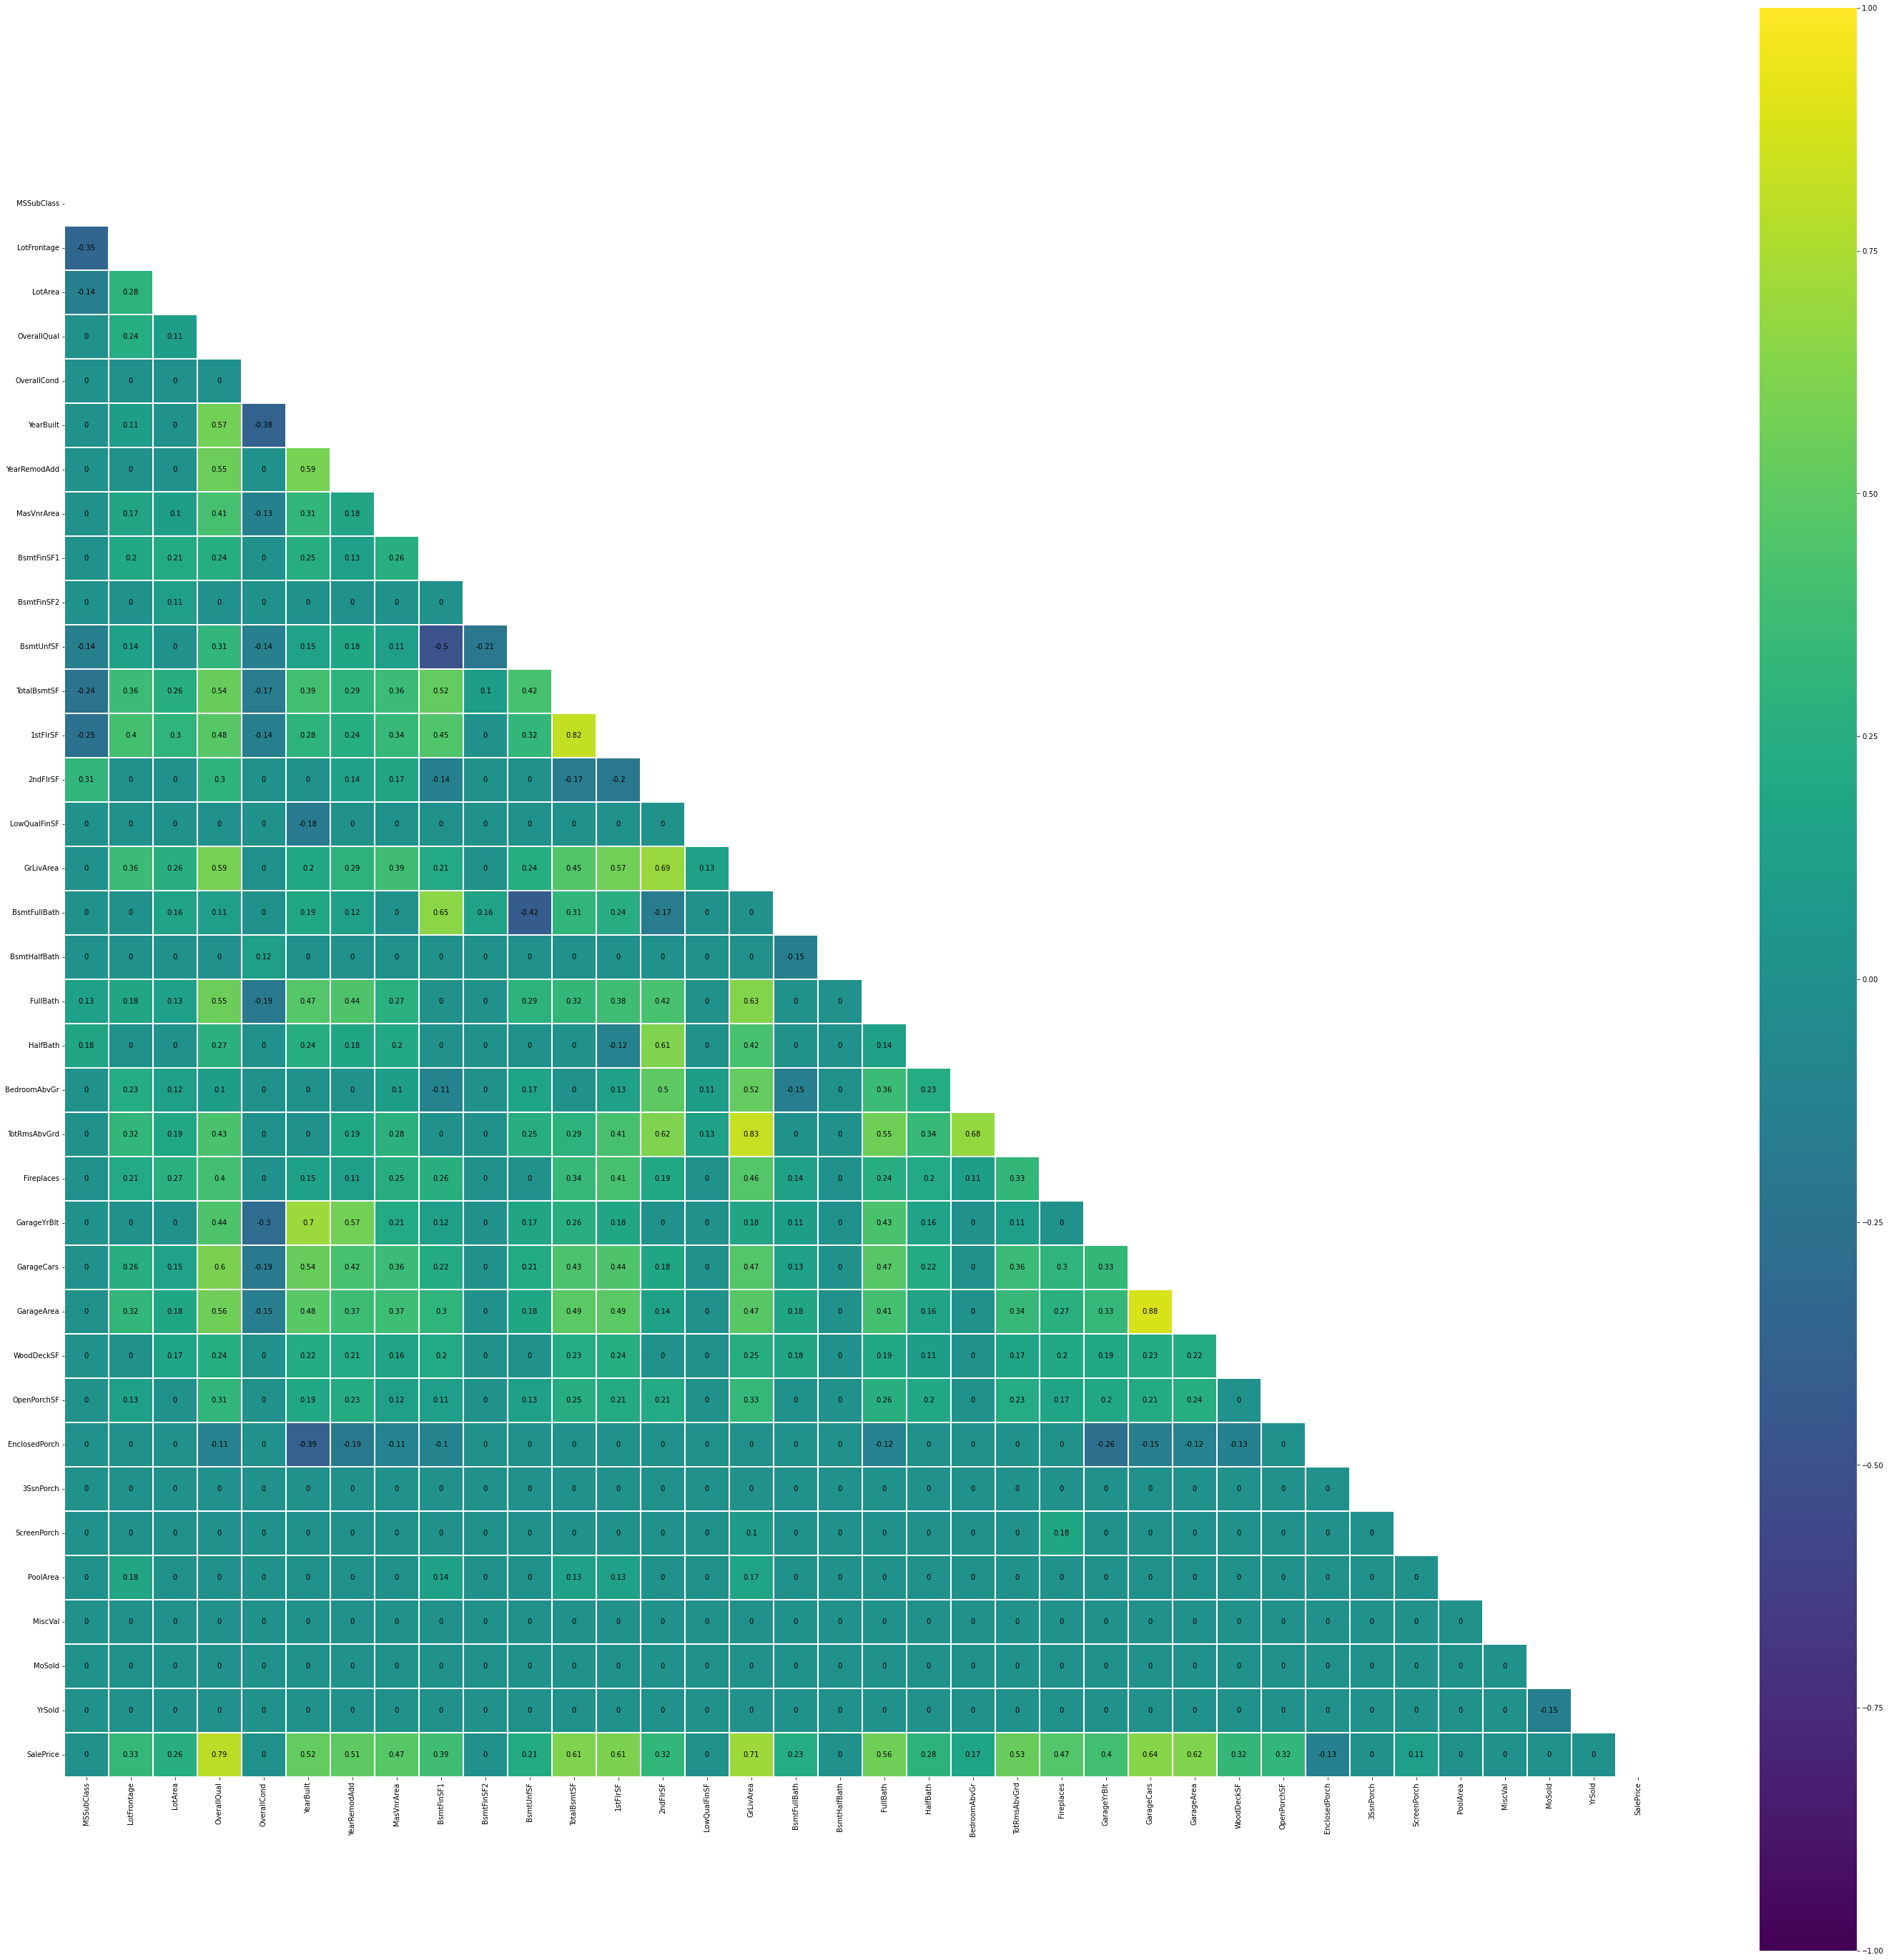

In [40]:
corr_mat = df_numeric.corr()

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Choose the color map
cmap = "viridis"

corr_mat[(corr_mat < 0.1) & (corr_mat > -0.1)] = 0 # Easier to view, don't really care obout weak correlations

# plot the heatmap
plt.figure(figsize=(50,50))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 10, "color": "black"}, square=True, cmap=cmap, annot=True)
plt.show()

Following this rule: 
##### Strengh of relationship

* |r| < 0.3 $\Rightarrow$ None or Very Weak
* 0.3 < |r| < 0.5 $\Rightarrow$ Weak
* 0.5 < |r| < 0.7 $\Rightarrow$ Moderate
* |r| > 0.7 $\Rightarrow$ Strong

#### <font color="asparagus"> *For better visibility, only showing the ones with |correlation| > 0.7* <font>

In [41]:
corr_mat[(corr_mat > 0) & (corr_mat < 0.7)] = 0
corr_mat[(corr_mat < 0) & (corr_mat > -0.7)] = 0

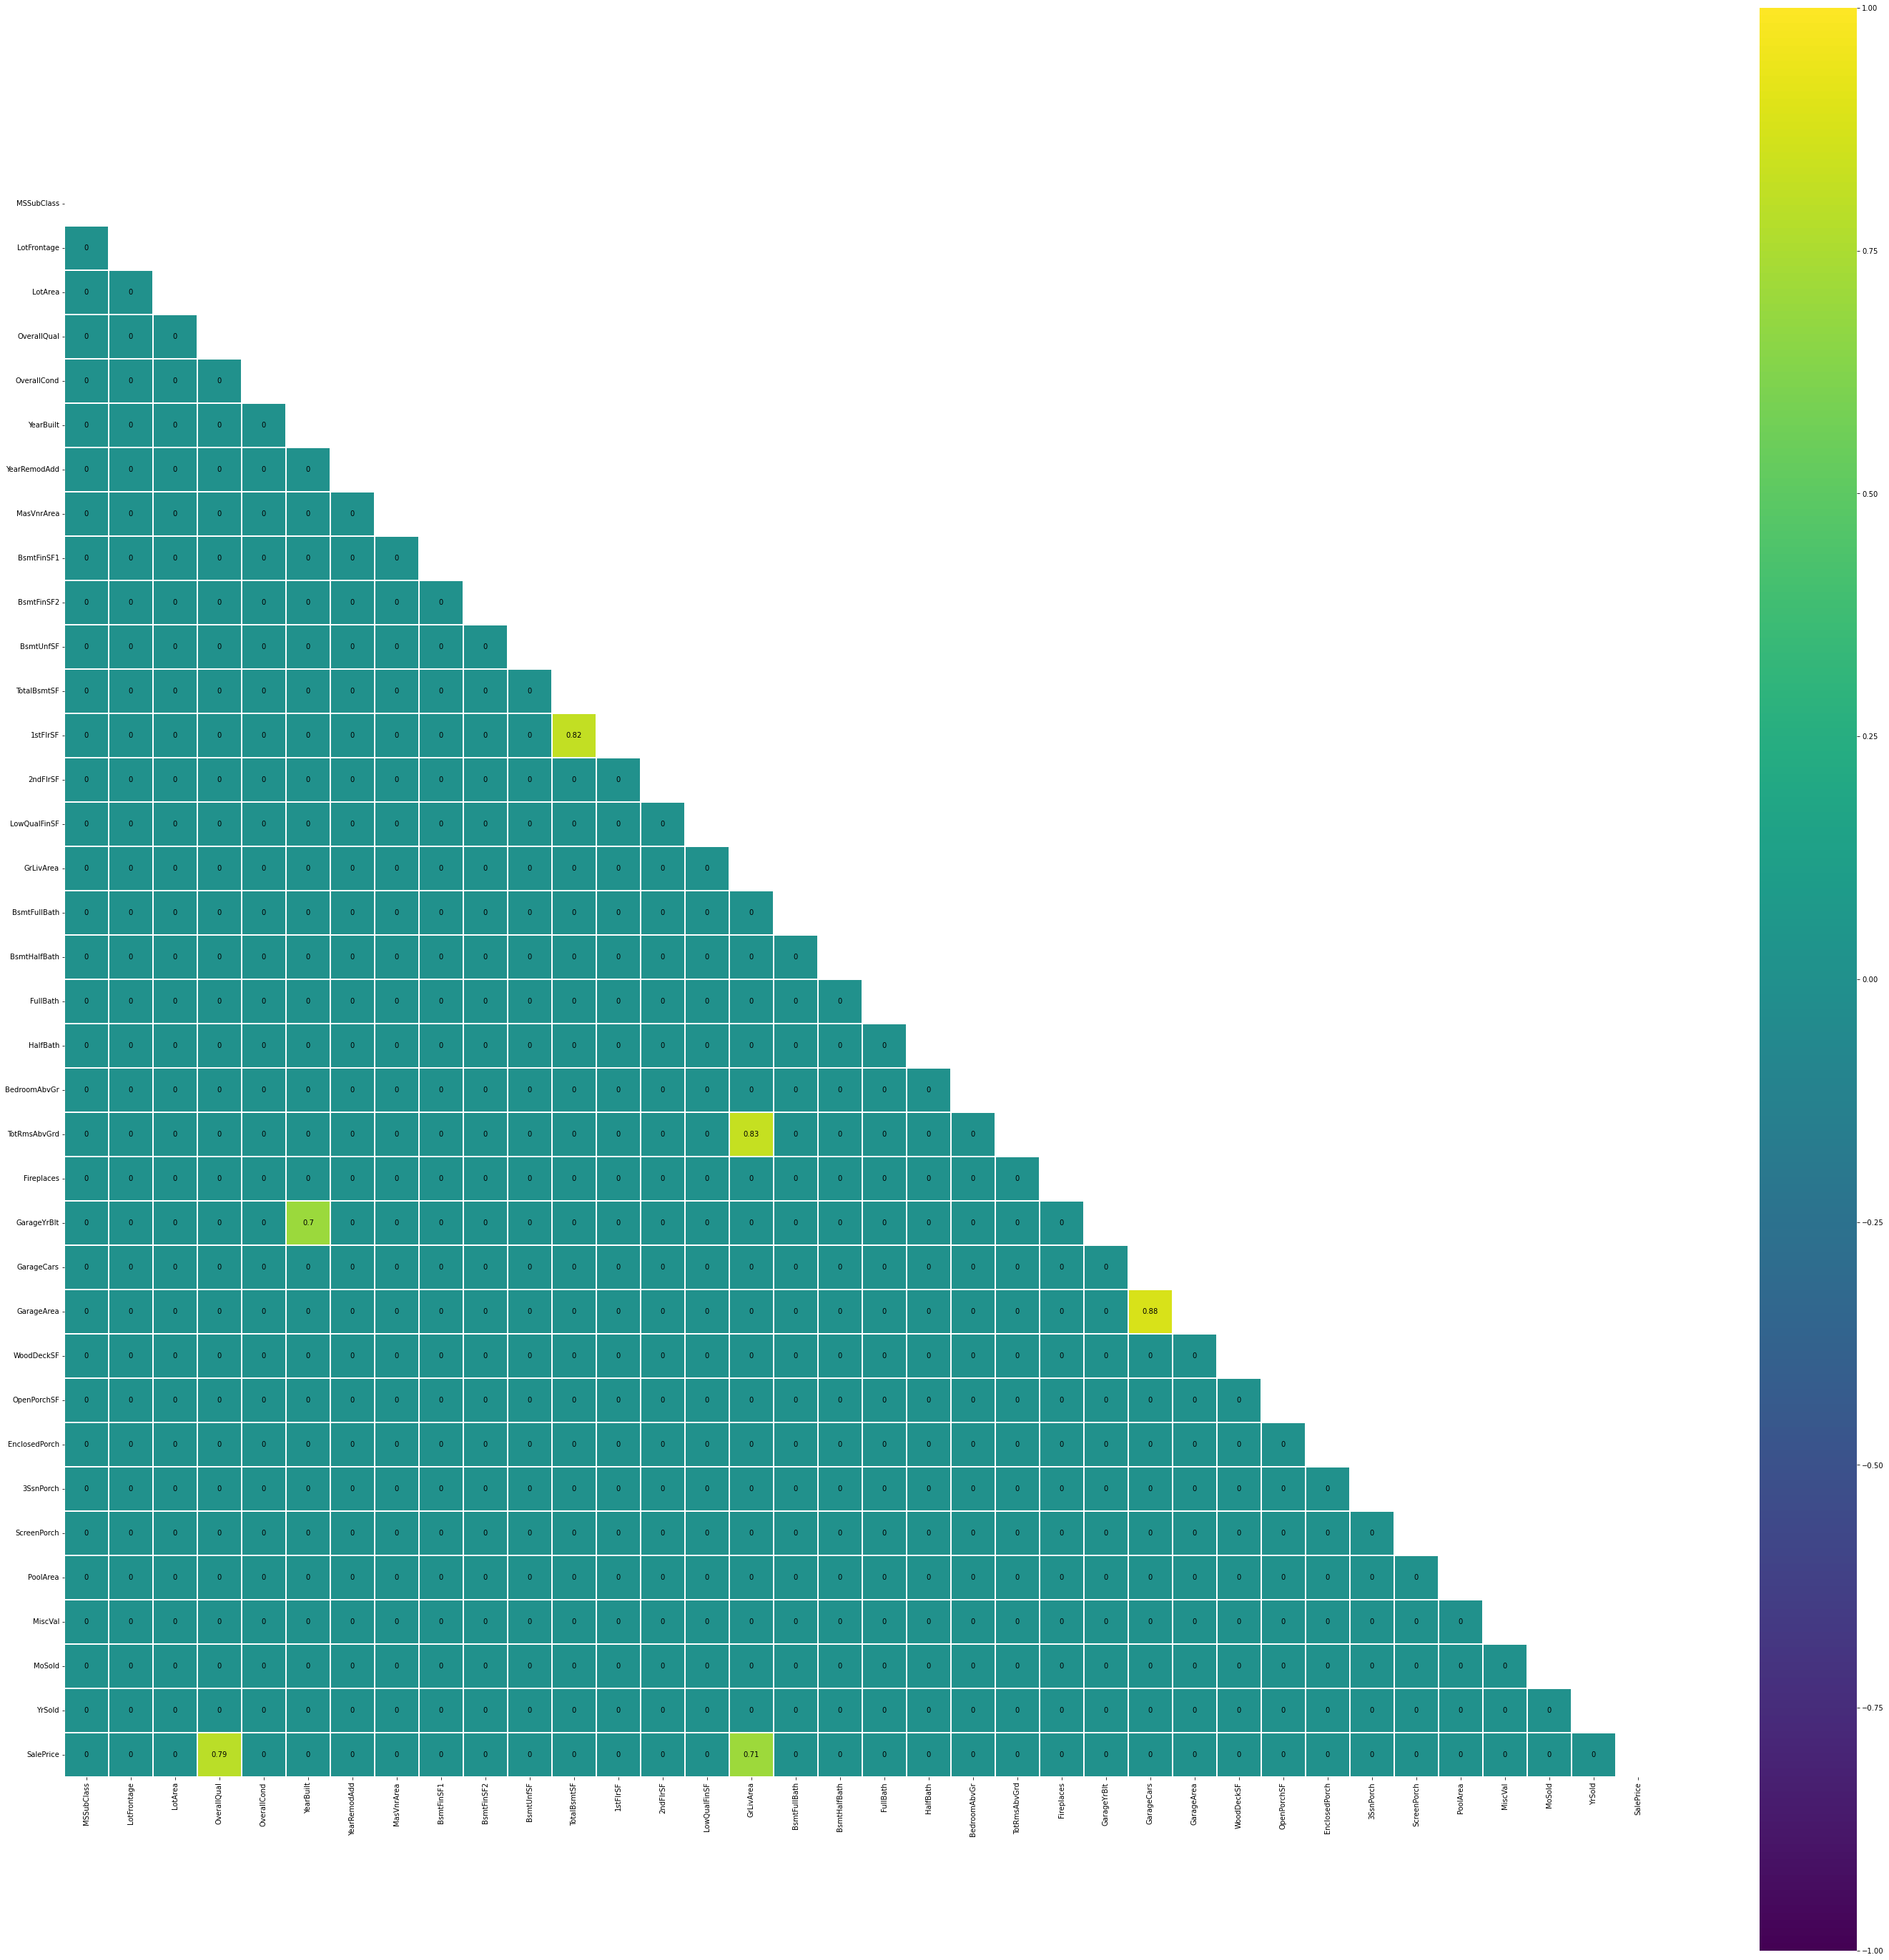

In [42]:
# plot the heatmap
plt.figure(figsize=(50,50))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 10, "color": "black"}, square=True, cmap=cmap, annot=True)
plt.show()

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ From the above figure, the following variables are highly correlated:
1. *1stFlrSF* and *TotalBsmntSF* .<br> 
2. *TotalRmsAbvGrd* and *GrLivArea* .<br> 
3. *GarageArea* and *GarageCars* .<br> 
2. *GarageYrBlt* and *YearBuilt* .<br> 
$\Rightarrow$ We will discard *TotalBsmntSF*, *TotalRmsAbvGrd*, *GarageCars*, *GarageYrBlt* and keep the remaining

In [43]:
corr_dropped_cols = ["TotalBsmtSF", "TotRmsAbvGrd", "GarageCars", "GarageYrBlt"]

In [44]:
df.drop(corr_dropped_cols, axis=1, inplace=True)

# <font color='goldenrod'> III. Handling categorical data </font>

#### Handling variables with just two values

In [45]:
for col in df.columns:
    if df[col].nunique() == 2:
        print(col)

Street
Utilities
CentralAir


In [46]:
df.Street = df.Street.map({"Pave": 1, "Grvl": 0})

In [47]:
df.CentralAir = df.CentralAir.map({"Y": 1, "N": 0})

In [48]:
df.Utilities = df.Utilities.map({"AllPub": 1, "NoSeWa": 0})

#### Not One hot encoding "OverallQual" and "OverallCond"

In [49]:
df.Exterior2nd

0       VinylSd
1       MetalSd
2       VinylSd
3       Wd Shng
4       VinylSd
         ...   
1455    VinylSd
1456    Plywood
1457    CmentBd
1458    MetalSd
1459    HdBoard
Name: Exterior2nd, Length: 1460, dtype: object

In [50]:
def obtain_cont_cat_cols(df):
    df_numeric = df.select_dtypes(include=np.number)
    cont_cols = df_numeric.columns
    df_numeric.drop("MSSubClass", axis=1, inplace=True)
    cat_cols = [col for col in df.columns if col not in cont_cols]
    return cont_cols, cat_cols

$\Rightarrow$ <font color="asparagus"> Let's drop the quasi constant categorical columns we accumulated earlier before we one hot encode the columns <font>

In [51]:
df.drop(columns=quasi_constant_cat_cols, axis=1, inplace=True)

In [52]:
cont_cols, cat_cols = obtain_cont_cat_cols(df)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
cat_cols.remove("Exterior2nd")

In [54]:
dummied_col = []

In [55]:
for col in cat_cols:
    if (df[col].nunique() > 2) & (df[col].nunique() <= 18):
        if (col != "OverallQual") & (col != "OverallCond"):
            print(col)
            dummied_col.append(col)
            df = pd.get_dummies(data=df, drop_first=True, prefix=col, columns=[col])

MSZoning
LotShape
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
BldgType
HouseStyle
RoofStyle
Exterior1st
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
Electrical
KitchenQual
Functional
GarageType
GarageFinish
PavedDrive
SaleType
SaleCondition


In [56]:
df = pd.get_dummies(data=df, drop_first=True, prefix="Exterior2nd", columns=["Exterior2nd"])

In [57]:
# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
#cols = df_numeric.columns
#col_list = list(cols)
#col_list.remove("SalePrice")

In [58]:
#scaler = MinMaxScaler()
#X_sc = scaler.fit_transform(df_numeric[col_list])

In [59]:
# scaling the features - necessary before using Ridge or Lasso
#from sklearn.preprocessing import scale, MinMaxScaler


#X_sc = pd.DataFrame(scale(df_numeric[col_list]))
#X_sc.columns = col_list
#X_sc.columns

In [60]:
#X_sc

$\Rightarrow$ <font color="asparagus"> Finally we are left with 166 columns <font>

In [61]:
df.shape

(1460, 184)

# <font color='goldenrod'> IV. Model building </font>

### <font color='skyblue'>  IV.1 Train test split<font>

In [62]:
y = df.pop("SalePrice")


In [63]:
X = df

In [64]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [65]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1021, 1021, 438, 438)

### <font color='skyblue'>  IV.2 Basic Linear Regression<font>

In [66]:
# Instantiate
lm = LinearRegression()

In [67]:
lm.fit(X_train, y_train)

LinearRegression()

In [68]:
def evaluate_model(lm, X_train, X_test, y_train, y_test):
    y_pred_train = lm.predict(X_train)
    y_pred_test = lm.predict(X_test)
    metric = {}
    
    r2_train_lr = r2_score(y_train, y_pred_train)
    metric["train_r2"] = round(r2_train_lr,3)
    print(r2_train_lr)
    
    r2_test_lr = r2_score(y_test, y_pred_test)
    metric["test_r2"] = round(r2_test_lr,3)
    print(r2_test_lr)
        
    rss1_lr = np.sum(np.square(y_train - y_pred_train))
    metric["rss_train"] = round(rss1_lr,3)

    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    metric["rss_test"] = round(rss2_lr,3)

    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    metric["rmse_train"] = round(mse_train_lr**0.5,3)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    metric["rmse_test"] = round(mse_test_lr**0.5,3)
    
    return y_pred_train, y_pred_test, metric

In [69]:
y_pred_train, y_pred_test, metric = evaluate_model(lm, X_train, X_test, y_train, y_test)

0.8925837323925558
0.8433184756370151


In [70]:
metric

{'train_r2': 0.893,
 'test_r2': 0.843,
 'rss_train': 685390849767.126,
 'rss_test': 441640175996.334,
 'rmse_train': 25909.336,
 'rmse_test': 31753.912}

### <font color='skyblue'>  IV.3 RFE <font>

In [71]:
df.shape[1]

183

$\Rightarrow$ <font color="asparagus"> Will do a divide and conquer to land on the optimum number of columns for this task. </font> <br>
$\Rightarrow$ <font color="asparagus"> The following recursive function does a divide and conquer has a maximum depth of 20, at the end of it, it will give us the r2 score on the training data for various number of columns tried  </font>

In [72]:
def divide_and_conquer(curr_r2_train, noColsToKeep, upperBound, lm, X_train, y_train, y_test, rfe_metric, depth=1):
    print("depth: ", depth)
    print("noColsToKeep: ", noColsToKeep)
    #print("rfe_metric: ", rfe_metric)
    if depth == 20:
        return rfe_metric
        
    # Fit RFE and obtain support of the rfe vector
    rfe = RFE(lm, noColsToKeep)
    rfe.fit(X_train, y_train)
    cols_to_keep = X_train.columns[rfe.support_]
    
    # Second pass: Train on the newly obtained columns from the support of RFE
    X_train_rfe = X_train[cols_to_keep]
    X_test_rfe = X_test[cols_to_keep]
    # Instantiate
    lm = LinearRegression()
    lm.fit(X_train_rfe, y_train)
    
    y_pred_train_rfe, y_pred_test_rfe, metric_rfe = evaluate_model(lm, X_train_rfe, X_test_rfe, y_train, y_test)
    #print("m ",metric_rfe)
    new_r2_train = metric_rfe["train_r2"]
    rfe_metric[int(noColsToKeep)] = new_r2_train
    # Third pass:
    delta = np.abs(curr_r2_train - new_r2_train)
    thr = 0.03
    #print("delta: ", delta)
    print("rfe: ", metric_rfe)
    
    if delta >= thr: # r2_score has dropped too low, increase features
        step_size = int((upperBound - noColsToKeep)/2)
        noColsToKeep = noColsToKeep + step_size
    else:  # r2_score is acceptable, try noColsToKeep/2
        upperBound = noColsToKeep
        noColsToKeep = int(noColsToKeep/2)
        
    depth += 1
    
    rfe_metric= divide_and_conquer(curr_r2_train, noColsToKeep, upperBound, lm,  X_train, y_train, y_test, rfe_metric, depth=depth)
    return rfe_metric 
    
    

In [73]:
noColsToKeep = int(df.shape[1]/2)

noColsToKeep

91

In [74]:
rfe_metric = {}

In [75]:
metric["train_r2"]

0.893

In [76]:
rfe_metric = divide_and_conquer(metric["train_r2"], noColsToKeep, X_train.shape[1],lm, X_train, y_train, y_test, rfe_metric)

depth:  1
noColsToKeep:  91


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=91 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8779299489221316
-337686507008.22974
rfe:  {'train_r2': 0.878, 'test_r2': -337686507008.23, 'rss_train': 778892228364.659, 'rss_test': 9.518411886371469e+23, 'rmse_train': 27620.136, 'rmse_test': 46617093417.704}
depth:  2
noColsToKeep:  45


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=45 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8571478226771853
-92704351.51430096
rfe:  {'train_r2': 0.857, 'test_r2': -92704351.514, 'rss_train': 911496716346.369, 'rss_test': 2.613069200500733e+20, 'rmse_train': 29878.905, 'rmse_test': 772393126.372}
depth:  3
noColsToKeep:  68


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=68 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8737581621445255
-167930582.21744394
rfe:  {'train_r2': 0.874, 'test_r2': -167930582.217, 'rss_train': 805511143248.205, 'rss_test': 4.733480391440463e+20, 'rmse_train': 28088.135, 'rmse_test': 1039568797.972}
depth:  4
noColsToKeep:  34


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=34 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8208500386496279
0.7789337961311785
rfe:  {'train_r2': 0.821, 'test_r2': 0.779, 'rss_train': 1143101943314.682, 'rss_test': 623122078882.025, 'rmse_train': 33460.283, 'rmse_test': 37718.075}
depth:  5
noColsToKeep:  51


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=51 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8471940233725745
-58394.528718159876
rfe:  {'train_r2': 0.847, 'test_r2': -58394.529, 'rss_train': 975008911619.534, 'rss_test': 1.646002085143092e+17, 'rmse_train': 30902.344, 'rmse_test': 19385550.361}
depth:  6
noColsToKeep:  59


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=59 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8692666772445922
-66240866.129881494
rfe:  {'train_r2': 0.869, 'test_r2': -66240866.13, 'rss_train': 834169955557.078, 'rss_test': 1.867139622002676e+20, 'rmse_train': 28583.434, 'rmse_test': 652907026.254}
depth:  7
noColsToKeep:  29


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=29 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.7193388544282524
0.6458143537980897
rfe:  {'train_r2': 0.719, 'test_r2': 0.646, 'rss_train': 1790814234609.509, 'rss_test': 998347519019.55, 'rmse_train': 41880.552, 'rmse_test': 47742.353}
depth:  8
noColsToKeep:  44


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=44 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8541043130553881
-668551394.653298
rfe:  {'train_r2': 0.854, 'test_r2': -668551394.653, 'rss_train': 930916434536.367, 'rss_test': 1.8844541961111454e+21, 'rmse_train': 30195.518, 'rmse_test': 2074224394.909}
depth:  9
noColsToKeep:  51


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=51 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8471940233725745
-58394.528718159876
rfe:  {'train_r2': 0.847, 'test_r2': -58394.529, 'rss_train': 975008911619.534, 'rss_test': 1.646002085143092e+17, 'rmse_train': 30902.344, 'rmse_test': 19385550.361}
depth:  10
noColsToKeep:  55


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=55 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8660907676084352
-515054674.0131686
rfe:  {'train_r2': 0.866, 'test_r2': -515054674.013, 'rss_train': 854434478359.753, 'rss_test': 1.45179106627513e+21, 'rmse_train': 28928.54, 'rmse_test': 1820601954.166}
depth:  11
noColsToKeep:  27


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=27 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.7192764348900795
0.6465463743414817
rfe:  {'train_r2': 0.719, 'test_r2': 0.647, 'rss_train': 1791212514881.792, 'rss_test': 996284163541.417, 'rmse_train': 41885.209, 'rmse_test': 47692.991}
depth:  12
noColsToKeep:  41


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=41 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8557129698890357
-20429483462.927185
rfe:  {'train_r2': 0.856, 'test_r2': -20429483462.927, 'rss_train': 920652079809.142, 'rss_test': 5.7584841028356215e+22, 'rmse_train': 30028.587, 'rmse_test': 11466134474.65}
depth:  13
noColsToKeep:  48


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=48 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8550196022050505
-4265497901169.3027
rfe:  {'train_r2': 0.855, 'test_r2': -4265497901169.302, 'rss_train': 925076250157.942, 'rss_test': 1.2023212382211722e+25, 'rmse_train': 30100.651, 'rmse_test': 165681189579.24}
depth:  14
noColsToKeep:  51


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=51 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8471940233725745
-58394.528718159876
rfe:  {'train_r2': 0.847, 'test_r2': -58394.529, 'rss_train': 975008911619.534, 'rss_test': 1.646002085143092e+17, 'rmse_train': 30902.344, 'rmse_test': 19385550.361}
depth:  15
noColsToKeep:  53


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=53 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8404372339805032
-47799934261.1838
rfe:  {'train_r2': 0.84, 'test_r2': -47799934261.184, 'rss_train': 1018121949581.844, 'rss_test': 1.3473427365473904e+23, 'rmse_train': 31578.175, 'rmse_test': 17538885281.814}
depth:  16
noColsToKeep:  54


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=54 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8522358313965857
-203828806077.7422
rfe:  {'train_r2': 0.852, 'test_r2': -203828806077.742, 'rss_train': 942838653213.533, 'rss_test': 5.7453480974049604e+23, 'rmse_train': 30388.259, 'rmse_test': 36217720937.544}
depth:  17
noColsToKeep:  54


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=54 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8522358313965857
-203828806077.7422
rfe:  {'train_r2': 0.852, 'test_r2': -203828806077.742, 'rss_train': 942838653213.533, 'rss_test': 5.7453480974049604e+23, 'rmse_train': 30388.259, 'rmse_test': 36217720937.544}
depth:  18
noColsToKeep:  54


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=54 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8522358313965857
-203828806077.7422
rfe:  {'train_r2': 0.852, 'test_r2': -203828806077.742, 'rss_train': 942838653213.533, 'rss_test': 5.7453480974049604e+23, 'rmse_train': 30388.259, 'rmse_test': 36217720937.544}
depth:  19
noColsToKeep:  54


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=54 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.8522358313965857
-203828806077.7422
rfe:  {'train_r2': 0.852, 'test_r2': -203828806077.742, 'rss_train': 942838653213.533, 'rss_test': 5.7453480974049604e+23, 'rmse_train': 30388.259, 'rmse_test': 36217720937.544}
depth:  20
noColsToKeep:  54


In [77]:
rfe_metric

{91: 0.878,
 45: 0.857,
 68: 0.874,
 34: 0.821,
 51: 0.847,
 59: 0.869,
 29: 0.719,
 44: 0.854,
 55: 0.866,
 27: 0.719,
 41: 0.856,
 48: 0.855,
 53: 0.84,
 54: 0.852}

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ Going down to 82 columns, gives a r2 score of 0.876 on training data. A drop of 0.015 from the base model. <br> 
$\Rightarrow$ Going down to around 50 columns drops it to around 0.87. A drop of 0.02
$\Rightarrow$ But going down even lower to 23, drops the r2 score too much: 0.723

In [78]:
import statsmodels.api as sm

In [79]:
rfe = RFE(lm, n_features_to_select=60)

In [80]:
rfe.fit(X_train, y_train)
cols_to_keep = X_train.columns[rfe.support_]
X_train_rfe = X_train[cols_to_keep]
X_test_rfe = X_test[cols_to_keep]

In [81]:
X_train_rfe_sm = sm.add_constant(X_train_rfe)
X_test_rfe_sm = sm.add_constant(X_test_rfe)

D:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()

In [83]:
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)

In [84]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8179081865974271

In [85]:
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [86]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8693407253635019

#### Base model stats

In [87]:
metric

{'train_r2': 0.893,
 'test_r2': 0.843,
 'rss_train': 685390849767.126,
 'rss_test': 441640175996.334,
 'rmse_train': 25909.336,
 'rmse_test': 31753.912}

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ With 60 feature, the train r2 score is ~ 0.87 while test r2 score is ~ 0.82 <br>
$\Rightarrow$ The base model had train r2 ~ 0.89 and test r2 ~ 0.84

Let's take a respite and do so manual elimination by monitoring p values and eliminating features with p value > 0.05. <br> We'll then compare the results of this experiment against directly deployed lasso/ridge regularization. <br> I'm hopeful that some feature elimination will come into play due to the nature of l1 norm and to some extent l2 norm which will reduce the redundant feature's coefficients.

### <font color='skyblue'>  IV.4 Some manual elimination based on p values of statsmodels' summary stats <font>

In [88]:
X_train_cached_post_rfe = X_train_rfe.copy()
X_test_cached_post_rfe = X_test_rfe.copy()
y_train_cached_post_rfe = y_train.copy()
y_test_cached_post_rfe = y_test.copy()


In [89]:
len(X_train_cached_post_rfe)

1021

In [90]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -11925.
No. Observations:                1021   AIC:                         2.397e+04
Df Residuals:                     962   BIC:                         2.426e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   4.18e+04   2.85e+04      1.468      0.142   -1.41e+04    9.77e+04
OverallQual            1.265e+04   1264.215     10.005      0.000    1.02e+04    1.51e+04
1stFlrSF                 22.2798      6.777      3.287      0.001       8.979      35.580
2ndFlrSF                 38.9599      6.829      5.705      0.000      25.558      52.361
LowQualFinSF            -29.7341     17.468     -1.702      0.089     -64.014       4.546
GrLivArea                31.5056      6.105      5.161      0.000      19.526      43.485
BsmtFullBath           1.248e+04   1964.971      6.350      0.000    8621.154    1.63e+04
MSZoning_FV            3.047e+04   1.53e+04      1.993      0.047     471.786    6.05e+04
MSZoning_RH            3.988e+04   1.47e+04      2.720      0.007    1.11e+04    6.87e+04
MSZoning_RL            4.541e+04   1.24e+04      3.674      0.000    2.12e+04    6.97e+04
MSZoning_RM            3.053e+04   1.24e+04      2.467      0.014    6239.982    5.48e+04
LotShape_IR3          -1.971e+04   1.03e+04     -1.911      0.056      -4e+04     527.746
LandContour_HLS        3.219e+04   7190.291      4.477      0.000    1.81e+04    4.63e+04
LandContour_Low         4.01e+04   7811.366      5.133      0.000    2.48e+04    5.54e+04
LandContour_Lvl        2.816e+04   5014.379      5.616      0.000    1.83e+04     3.8e+04
LotConfig_CulDSac      1.258e+04   4017.830      3.131      0.002    4693.809    2.05e+04
Neighborhood_Crawfor   2.227e+04   5704.852      3.903      0.000    1.11e+04    3.35e+04
Neighborhood_Edwards  -2.512e+04   3987.483     -6.299      0.000   -3.29e+04   -1.73e+04
Neighborhood_Mitchel  -1.081e+04   5229.376     -2.067      0.039   -2.11e+04    -547.189
Neighborhood_NAmes    -1.105e+04   3202.773     -3.449      0.001   -1.73e+04   -4762.318
Neighborhood_NoRidge   5.522e+04   5944.575      9.289      0.000    4.36e+04    6.69e+04
Neighborhood_NridgHt   3.266e+04   5081.285      6.428      0.000    2.27e+04    4.26e+04
Neighborhood_Somerst   3.094e+04   8202.296      3.773      0.000    1.48e+04     4.7e+04
Condition1_Norm        1.549e+04   2908.034      5.326      0.000    9780.251    2.12e+04
Condition1_PosA        2.098e+04   1.28e+04      1.641      0.101   -4110.897    4.61e+04
BldgType_2fmCon       -1.585e+04   6690.667     -2.369      0.018    -2.9e+04   -2717.150
BldgType_Duplex       -1.969e+04   5150.794     -3.823      0.000   -2.98e+04   -9584.230
BldgType_Twnhs        -2.122e+04   5660.679     -3.749      0.000   -3.23e+04   -1.01e+04
BldgType_TwnhsE        -1.53e+04   3924.130     -3.898      0.000    -2.3e+04   -7594.191
HouseStyle_1Story      1.566e+04   3383.329      4.630      0.000    9024.782    2.23e+04
HouseStyle_2.5Fin     -2.013e+04    1.8e+04     -1.120      0.263   -5.54e+04    1.51e+04
HouseStyle_2.5Unf     -

#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ Exterior1st_AsphShn, Exterior1st_ImStucc, Foundation_Stone, BsmtCond_Po, SaleType_Con, SaleType_ConLD have p values > 0.05. <br>
$\Rightarrow$ Instead of dropping all at once, let's drop them one at a time and look at the summary stats to see the movement of p values. 

#### <font color="asparagus"> $\Rightarrow$ Exterior1st_AsphShn

In [91]:
X_train_rfe_sm.drop("Exterior1st_AsphShn", axis=1, inplace=True)
X_test_rfe_sm.drop("Exterior1st_AsphShn", axis=1, inplace=True)

In [92]:
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()

In [93]:
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [94]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8178365417663088

In [95]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8692653776787014

In [96]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     112.3
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -11925.
No. Observations:                1021   AIC:                         2.397e+04
Df Residuals:                     963   BIC:                         2.425e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.236e+04   2.85e+04      1.489      0.137   -1.35e+04    9.82e+04
OverallQual            1.263e+04   1263.592      9.993      0.000    1.01e+04    1.51e+04
1stFlrSF                 22.2321      6.776      3.281      0.001       8.935      35.529
2ndFlrSF                 39.0702      6.826      5.724      0.000      25.675      52.465
LowQualFinSF            -29.8345     17.464     -1.708      0.088     -64.105       4.437
GrLivArea                31.4679      6.103      5.156      0.000      19.491      43.445
BsmtFullBath           1.253e+04   1963.401      6.380      0.000    8673.554    1.64e+04
MSZoning_FV            3.048e+04   1.53e+04      1.995      0.046     492.040    6.05e+04
MSZoning_RH            4.001e+04   1.47e+04      2.729      0.006    1.12e+04    6.88e+04
MSZoning_RL            4.545e+04   1.24e+04      3.678      0.000    2.12e+04    6.97e+04
MSZoning_RM            3.057e+04   1.24e+04      2.471      0.014    6289.079    5.49e+04
LotShape_IR3          -1.975e+04   1.03e+04     -1.915      0.056      -4e+04     487.215
LandContour_HLS         3.21e+04   7187.687      4.466      0.000     1.8e+04    4.62e+04
LandContour_Low        4.003e+04   7809.055      5.126      0.000    2.47e+04    5.54e+04
LandContour_Lvl        2.809e+04   5012.316      5.605      0.000    1.83e+04    3.79e+04
LotConfig_CulDSac      1.256e+04   4016.829      3.127      0.002    4677.924    2.04e+04
Neighborhood_Crawfor   2.228e+04   5703.493      3.907      0.000    1.11e+04    3.35e+04
Neighborhood_Edwards   -2.54e+04   3968.077     -6.402      0.000   -3.32e+04   -1.76e+04
Neighborhood_Mitchel  -1.071e+04   5226.557     -2.050      0.041    -2.1e+04    -456.096
Neighborhood_NAmes      -1.1e+04   3201.336     -3.435      0.001   -1.73e+04   -4715.403
Neighborhood_NoRidge   5.523e+04   5943.180      9.293      0.000    4.36e+04    6.69e+04
Neighborhood_NridgHt   3.268e+04   5080.020      6.434      0.000    2.27e+04    4.27e+04
Neighborhood_Somerst   3.096e+04   8200.363      3.776      0.000    1.49e+04    4.71e+04
Condition1_Norm        1.542e+04   2906.019      5.307      0.000    9718.394    2.11e+04
Condition1_PosA        2.093e+04   1.28e+04      1.637      0.102   -4157.010     4.6e+04
BldgType_2fmCon       -1.589e+04   6688.832     -2.376      0.018    -2.9e+04   -2766.982
BldgType_Duplex       -2.024e+04   5096.152     -3.972      0.000   -3.02e+04   -1.02e+04
BldgType_Twnhs        -2.122e+04   5659.367     -3.749      0.000   -3.23e+04   -1.01e+04
BldgType_TwnhsE        -1.53e+04   3923.217     -3.900      0.000    -2.3e+04   -7600.948
HouseStyle_1Story      1.565e+04   3382.462      4.626      0.000    9008.709    2.23e+04
HouseStyle_2.5Fin     -2.021e+04    1.8e+04     -1.125      0.261   -5.55e+04     1.5e+04
HouseStyle_2.5Unf     -

#### <font color="asparagus"> $\Rightarrow$ Exterior1st_ImStucc

In [97]:
X_train_rfe_sm.drop("Exterior1st_ImStucc", axis=1, inplace=True)
X_test_rfe_sm.drop("Exterior1st_ImStucc", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [98]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8178328241040127

In [99]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8691958377699245

In [100]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     114.4
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -11925.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     964   BIC:                         2.425e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.247e+04   2.84e+04      1.493      0.136   -1.33e+04    9.83e+04
OverallQual            1.259e+04   1262.289      9.975      0.000    1.01e+04    1.51e+04
1stFlrSF                 22.2243      6.774      3.281      0.001       8.931      35.518
2ndFlrSF                 39.2140      6.821      5.749      0.000      25.828      52.600
LowQualFinSF            -29.9012     17.459     -1.713      0.087     -64.163       4.361
GrLivArea                31.5371      6.101      5.169      0.000      19.565      43.509
BsmtFullBath            1.25e+04   1962.580      6.370      0.000    8649.616    1.64e+04
MSZoning_FV            3.047e+04   1.53e+04      1.994      0.046     489.150    6.04e+04
MSZoning_RH            4.004e+04   1.47e+04      2.732      0.006    1.13e+04    6.88e+04
MSZoning_RL            4.549e+04   1.24e+04      3.682      0.000    2.12e+04    6.97e+04
MSZoning_RM             3.06e+04   1.24e+04      2.474      0.014    6327.646    5.49e+04
LotShape_IR3          -1.979e+04   1.03e+04     -1.920      0.055      -4e+04     439.276
LandContour_HLS        3.211e+04   7185.863      4.468      0.000     1.8e+04    4.62e+04
LandContour_Low        4.005e+04   7807.002      5.131      0.000    2.47e+04    5.54e+04
LandContour_Lvl        2.811e+04   5010.996      5.609      0.000    1.83e+04    3.79e+04
LotConfig_CulDSac      1.263e+04   4014.772      3.145      0.002    4747.419    2.05e+04
Neighborhood_Crawfor   2.226e+04   5701.980      3.904      0.000    1.11e+04    3.35e+04
Neighborhood_Edwards  -2.541e+04   3967.049     -6.406      0.000   -3.32e+04   -1.76e+04
Neighborhood_Mitchel  -1.071e+04   5225.224     -2.049      0.041    -2.1e+04    -451.059
Neighborhood_NAmes    -1.098e+04   3200.460     -3.432      0.001   -1.73e+04   -4702.396
Neighborhood_NoRidge   5.451e+04   5854.189      9.311      0.000     4.3e+04     6.6e+04
Neighborhood_NridgHt   3.269e+04   5078.732      6.436      0.000    2.27e+04    4.27e+04
Neighborhood_Somerst   3.102e+04   8197.962      3.783      0.000    1.49e+04    4.71e+04
Condition1_Norm        1.545e+04   2904.988      5.319      0.000    9750.103    2.12e+04
Condition1_PosA        2.093e+04   1.28e+04      1.638      0.102   -4145.765     4.6e+04
BldgType_2fmCon       -1.593e+04   6686.966     -2.382      0.017   -2.91e+04   -2805.215
BldgType_Duplex       -2.028e+04   5094.582     -3.981      0.000   -3.03e+04   -1.03e+04
BldgType_Twnhs         -2.12e+04   5657.898     -3.748      0.000   -3.23e+04   -1.01e+04
BldgType_TwnhsE       -1.524e+04   3921.378     -3.887      0.000   -2.29e+04   -7546.239
HouseStyle_1Story      1.566e+04   3381.584      4.630      0.000    9019.176    2.23e+04
HouseStyle_2.5Fin      -2.04e+04    1.8e+04     -1.136      0.256   -5.56e+04    1.48e+04
HouseStyle_2.5Unf      

#### <font color="asparagus"> $\Rightarrow$ Foundation_Stone

In [101]:
X_train_rfe_sm.drop("Foundation_Stone", axis=1, inplace=True)
X_test_rfe_sm.drop("Foundation_Stone", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [102]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8180006836419922

In [103]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8691117590518481

#### <font color="asparagus"> $\Rightarrow$ BsmtCond_Po

In [104]:
X_train_rfe_sm.drop("BsmtCond_Po", axis=1, inplace=True)
X_test_rfe_sm.drop("BsmtCond_Po", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [105]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8201083465507065

In [106]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.868797243547513

#### <font color="asparagus"> $\Rightarrow$ SaleType_Con

In [107]:
X_train_rfe_sm.drop("SaleType_Con", axis=1, inplace=True)
X_test_rfe_sm.drop("SaleType_Con", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [108]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8200652318999833

In [109]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8686277658934489

In [110]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     120.6
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:14   Log-Likelihood:                -11927.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     967   BIC:                         2.423e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.386e+04   2.84e+04      1.544      0.123   -1.19e+04    9.96e+04
OverallQual            1.286e+04   1253.086     10.266      0.000    1.04e+04    1.53e+04
1stFlrSF                 21.2861      6.754      3.152      0.002       8.032      34.541
2ndFlrSF                 38.6092      6.790      5.686      0.000      25.284      51.934
LowQualFinSF            -27.7505     17.398     -1.595      0.111     -61.893       6.392
GrLivArea                32.1448      6.093      5.276      0.000      20.188      44.102
BsmtFullBath           1.253e+04   1960.960      6.391      0.000    8684.429    1.64e+04
MSZoning_FV            2.826e+04   1.52e+04      1.860      0.063   -1559.829    5.81e+04
MSZoning_RH             3.75e+04   1.46e+04      2.571      0.010    8878.613    6.61e+04
MSZoning_RL            4.264e+04   1.22e+04      3.484      0.001    1.86e+04    6.67e+04
MSZoning_RM            2.811e+04   1.23e+04      2.290      0.022    4025.280    5.22e+04
LotShape_IR3          -1.953e+04   1.03e+04     -1.894      0.059   -3.98e+04     706.266
LandContour_HLS        3.167e+04   7184.874      4.407      0.000    1.76e+04    4.58e+04
LandContour_Low        3.781e+04   7688.475      4.917      0.000    2.27e+04    5.29e+04
LandContour_Lvl        2.771e+04   4999.160      5.543      0.000    1.79e+04    3.75e+04
LotConfig_CulDSac      1.309e+04   4004.471      3.270      0.001    5234.729     2.1e+04
Neighborhood_Crawfor   2.199e+04   5703.930      3.856      0.000    1.08e+04    3.32e+04
Neighborhood_Edwards  -2.592e+04   3957.003     -6.551      0.000   -3.37e+04   -1.82e+04
Neighborhood_Mitchel  -1.061e+04   5226.764     -2.030      0.043   -2.09e+04    -353.815
Neighborhood_NAmes      -1.1e+04   3194.903     -3.444      0.001   -1.73e+04   -4734.279
Neighborhood_NoRidge   5.417e+04   5851.991      9.256      0.000    4.27e+04    6.56e+04
Neighborhood_NridgHt   3.257e+04   5080.754      6.411      0.000    2.26e+04    4.25e+04
Neighborhood_Somerst   3.074e+04   8201.089      3.748      0.000    1.46e+04    4.68e+04
Condition1_Norm        1.543e+04   2899.087      5.322      0.000    9738.359    2.11e+04
Condition1_PosA        2.033e+04   1.28e+04      1.591      0.112   -4748.316    4.54e+04
BldgType_2fmCon       -1.443e+04   6629.720     -2.177      0.030   -2.74e+04   -1421.043
BldgType_Duplex        -1.98e+04   5087.794     -3.891      0.000   -2.98e+04   -9813.141
BldgType_Twnhs        -2.158e+04   5658.249     -3.814      0.000   -3.27e+04   -1.05e+04
BldgType_TwnhsE       -1.529e+04   3918.730     -3.902      0.000    -2.3e+04   -7602.637
HouseStyle_1Story      1.589e+04   3376.325      4.705      0.000    9261.243    2.25e+04
HouseStyle_2.5Fin     -1.976e+04    1.8e+04     -1.100      0.271    -5.5e+04    1.55e+04
HouseStyle_2.5Unf     -

#### <font color="asparagus"> $\Rightarrow$ SaleType_ConLD

In [111]:
X_train_rfe_sm.drop("SaleType_ConLD", axis=1, inplace=True)
X_test_rfe_sm.drop("SaleType_ConLD", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [112]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8205916959466443

In [113]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8685157886701952

In [114]:
len(X_train_rfe_sm.columns)

55

In [115]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     123.0
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11928.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     968   BIC:                         2.422e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.438e+04   2.84e+04      1.562      0.119   -1.14e+04       1e+05
OverallQual            1.292e+04   1251.240     10.329      0.000    1.05e+04    1.54e+04
1stFlrSF                 20.6493      6.717      3.074      0.002       7.468      33.831
2ndFlrSF                 38.3740      6.785      5.656      0.000      25.060      51.688
LowQualFinSF            -26.3160     17.325     -1.519      0.129     -60.315       7.683
GrLivArea                32.7073      6.061      5.396      0.000      20.813      44.601
BsmtFullBath           1.253e+04   1960.771      6.389      0.000    8678.838    1.64e+04
MSZoning_FV             2.69e+04   1.51e+04      1.779      0.076   -2770.662    5.66e+04
MSZoning_RH              3.6e+04   1.45e+04      2.485      0.013    7566.289    6.44e+04
MSZoning_RL            4.131e+04   1.22e+04      3.400      0.001    1.75e+04    6.52e+04
MSZoning_RM            2.663e+04   1.22e+04      2.190      0.029    2765.741    5.05e+04
LotShape_IR3          -1.935e+04   1.03e+04     -1.877      0.061   -3.96e+04     875.870
LandContour_HLS        3.177e+04   7183.248      4.423      0.000    1.77e+04    4.59e+04
LandContour_Low         3.78e+04   7687.769      4.917      0.000    2.27e+04    5.29e+04
LandContour_Lvl        2.793e+04   4992.762      5.594      0.000    1.81e+04    3.77e+04
LotConfig_CulDSac      1.309e+04   4004.105      3.269      0.001    5232.099    2.09e+04
Neighborhood_Crawfor   2.203e+04   5703.277      3.862      0.000    1.08e+04    3.32e+04
Neighborhood_Edwards  -2.563e+04   3943.635     -6.499      0.000   -3.34e+04   -1.79e+04
Neighborhood_Mitchel  -1.057e+04   5226.065     -2.022      0.043   -2.08e+04    -311.190
Neighborhood_NAmes    -1.094e+04   3193.773     -3.425      0.001   -1.72e+04   -4670.014
Neighborhood_NoRidge   5.405e+04   5850.000      9.239      0.000    4.26e+04    6.55e+04
Neighborhood_NridgHt   3.253e+04   5080.061      6.403      0.000    2.26e+04    4.25e+04
Neighborhood_Somerst   3.071e+04   8200.292      3.745      0.000    1.46e+04    4.68e+04
Condition1_Norm        1.544e+04   2898.800      5.326      0.000    9749.525    2.11e+04
Condition1_PosA        2.022e+04   1.28e+04      1.582      0.114   -4863.669    4.53e+04
BldgType_2fmCon       -1.323e+04   6494.853     -2.036      0.042    -2.6e+04    -480.466
BldgType_Duplex       -1.981e+04   5087.320     -3.894      0.000   -2.98e+04   -9824.095
BldgType_Twnhs        -2.143e+04   5655.346     -3.790      0.000   -3.25e+04   -1.03e+04
BldgType_TwnhsE       -1.522e+04   3917.624     -3.886      0.000   -2.29e+04   -7535.208
HouseStyle_1Story      1.586e+04   3375.917      4.699      0.000    9238.314    2.25e+04
HouseStyle_2.5Fin     -2.103e+04   1.79e+04     -1.175      0.240   -5.62e+04    1.41e+04
HouseStyle_2.5Unf     -

#### <font color="asparagus"> $\Rightarrow$ Exterior1st_CBlock

In [116]:
X_train_rfe_sm.drop("Exterior1st_CBlock", axis=1, inplace=True)
X_test_rfe_sm.drop("Exterior1st_CBlock", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [117]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.820626077677747

In [118]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.868465305853405

In [119]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     125.4
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11928.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     969   BIC:                         2.422e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.517e+04   2.84e+04      1.592      0.112   -1.05e+04    1.01e+05
OverallQual            1.295e+04   1250.020     10.361      0.000    1.05e+04    1.54e+04
1stFlrSF                 20.3808      6.700      3.042      0.002       7.232      33.530
2ndFlrSF                 38.0929      6.767      5.629      0.000      24.814      51.372
LowQualFinSF            -25.5549     17.274     -1.479      0.139     -59.454       8.344
GrLivArea                32.9188      6.049      5.442      0.000      21.048      44.789
BsmtFullBath           1.255e+04   1959.676      6.405      0.000    8706.862    1.64e+04
MSZoning_FV              2.6e+04    1.5e+04      1.728      0.084   -3520.246    5.55e+04
MSZoning_RH            3.524e+04   1.44e+04      2.442      0.015    6921.718    6.36e+04
MSZoning_RL            4.039e+04   1.21e+04      3.351      0.001    1.67e+04     6.4e+04
MSZoning_RM            2.584e+04   1.21e+04      2.137      0.033    2115.521    4.96e+04
LotShape_IR3          -1.936e+04   1.03e+04     -1.879      0.061   -3.96e+04     862.683
LandContour_HLS        3.171e+04   7180.261      4.417      0.000    1.76e+04    4.58e+04
LandContour_Low        3.771e+04   7684.021      4.908      0.000    2.26e+04    5.28e+04
LandContour_Lvl        2.781e+04   4987.391      5.576      0.000     1.8e+04    3.76e+04
LotConfig_CulDSac      1.313e+04   4002.208      3.281      0.001    5278.044     2.1e+04
Neighborhood_Crawfor   2.201e+04   5701.365      3.861      0.000    1.08e+04    3.32e+04
Neighborhood_Edwards  -2.555e+04   3940.241     -6.485      0.000   -3.33e+04   -1.78e+04
Neighborhood_Mitchel  -1.053e+04   5224.047     -2.016      0.044   -2.08e+04    -279.723
Neighborhood_NAmes    -1.085e+04   3189.411     -3.401      0.001   -1.71e+04   -4589.725
Neighborhood_NoRidge   5.406e+04   5848.046      9.245      0.000    4.26e+04    6.55e+04
Neighborhood_NridgHt   3.253e+04   5078.409      6.406      0.000    2.26e+04    4.25e+04
Neighborhood_Somerst   3.071e+04   8197.631      3.747      0.000    1.46e+04    4.68e+04
Condition1_Norm        1.551e+04   2895.523      5.356      0.000    9826.937    2.12e+04
Condition1_PosA         2.03e+04   1.28e+04      1.589      0.112   -4767.045    4.54e+04
BldgType_2fmCon       -1.315e+04   6491.447     -2.025      0.043   -2.59e+04    -407.952
BldgType_Duplex       -1.967e+04   5080.876     -3.872      0.000   -2.96e+04   -9702.114
BldgType_Twnhs        -2.148e+04   5652.950     -3.800      0.000   -3.26e+04   -1.04e+04
BldgType_TwnhsE       -1.528e+04   3915.124     -3.904      0.000    -2.3e+04   -7599.968
HouseStyle_1Story      1.599e+04   3368.090      4.748      0.000    9383.612    2.26e+04
HouseStyle_2.5Fin     -2.049e+04   1.79e+04     -1.146      0.252   -5.56e+04    1.46e+04
HouseStyle_2.5Unf     -

#### <font color="asparagus"> $\Rightarrow$ ExterQual_Fa

In [120]:
X_train_rfe_sm.drop("ExterQual_Fa", axis=1, inplace=True)
X_test_rfe_sm.drop("ExterQual_Fa", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [121]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8205219660406221

In [122]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8684436694644102

In [123]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     128.1
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11928.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     970   BIC:                         2.421e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   4.68e+04   2.81e+04      1.668      0.096   -8254.251    1.02e+05
OverallQual            1.292e+04   1247.744     10.359      0.000    1.05e+04    1.54e+04
1stFlrSF                 20.0508      6.646      3.017      0.003       7.008      33.094
2ndFlrSF                 37.8898      6.745      5.618      0.000      24.654      51.125
LowQualFinSF            -24.7579     17.151     -1.444      0.149     -58.415       8.900
GrLivArea                33.1827      6.010      5.521      0.000      21.388      44.977
BsmtFullBath           1.255e+04   1958.812      6.407      0.000    8705.481    1.64e+04
MSZoning_FV            2.495e+04   1.48e+04      1.685      0.092   -4102.442     5.4e+04
MSZoning_RH            3.432e+04   1.42e+04      2.410      0.016    6376.894    6.23e+04
MSZoning_RL            3.933e+04   1.17e+04      3.347      0.001    1.63e+04    6.24e+04
MSZoning_RM            2.478e+04   1.18e+04      2.102      0.036    1644.052    4.79e+04
LotShape_IR3          -1.942e+04   1.03e+04     -1.886      0.060   -3.96e+04     789.985
LandContour_HLS         3.17e+04   7177.059      4.417      0.000    1.76e+04    4.58e+04
LandContour_Low        3.764e+04   7678.302      4.902      0.000    2.26e+04    5.27e+04
LandContour_Lvl         2.77e+04   4977.152      5.565      0.000    1.79e+04    3.75e+04
LotConfig_CulDSac      1.313e+04   4000.473      3.283      0.001    5282.547     2.1e+04
Neighborhood_Crawfor   2.195e+04   5696.813      3.853      0.000    1.08e+04    3.31e+04
Neighborhood_Edwards  -2.558e+04   3937.613     -6.497      0.000   -3.33e+04   -1.79e+04
Neighborhood_Mitchel  -1.054e+04   5221.756     -2.018      0.044   -2.08e+04    -290.892
Neighborhood_NAmes    -1.086e+04   3187.905     -3.407      0.001   -1.71e+04   -4603.919
Neighborhood_NoRidge   5.412e+04   5843.962      9.260      0.000    4.26e+04    6.56e+04
Neighborhood_NridgHt   3.256e+04   5075.760      6.414      0.000    2.26e+04    4.25e+04
Neighborhood_Somerst   3.072e+04   8194.053      3.749      0.000    1.46e+04    4.68e+04
Condition1_Norm        1.542e+04   2885.859      5.344      0.000    9757.853    2.11e+04
Condition1_PosA        2.025e+04   1.28e+04      1.586      0.113   -4803.812    4.53e+04
BldgType_2fmCon       -1.311e+04   6487.996     -2.021      0.044   -2.58e+04    -378.401
BldgType_Duplex       -1.961e+04   5076.513     -3.864      0.000   -2.96e+04   -9651.517
BldgType_Twnhs        -2.148e+04   5650.485     -3.801      0.000   -3.26e+04   -1.04e+04
BldgType_TwnhsE       -1.529e+04   3913.357     -3.908      0.000    -2.3e+04   -7612.818
HouseStyle_1Story      1.607e+04   3361.449      4.780      0.000    9471.225    2.27e+04
HouseStyle_2.5Fin     -1.991e+04   1.78e+04     -1.118      0.264   -5.49e+04     1.5e+04
HouseStyle_2.5Unf      

#### <font color="asparagus"> $\Rightarrow$ HouseStyle_2.5Fin

In [124]:
X_train_rfe_sm.drop("HouseStyle_2.5Fin", axis=1, inplace=True)
X_test_rfe_sm.drop("HouseStyle_2.5Fin", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [125]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8208460420108302

In [126]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8682741700632488

In [127]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     130.6
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11929.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     971   BIC:                         2.420e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.743e+04   2.81e+04      1.691      0.091   -7627.121    1.02e+05
OverallQual            1.298e+04   1246.755     10.415      0.000    1.05e+04    1.54e+04
1stFlrSF                 23.0798      6.070      3.802      0.000      11.168      34.991
2ndFlrSF                 39.4880      6.592      5.990      0.000      26.551      52.425
LowQualFinSF            -32.5545     15.671     -2.077      0.038     -63.308      -1.801
GrLivArea                30.0133      5.300      5.663      0.000      19.612      40.414
BsmtFullBath            1.25e+04   1958.649      6.384      0.000    8660.736    1.63e+04
MSZoning_FV            2.402e+04   1.48e+04      1.625      0.104   -4986.572     5.3e+04
MSZoning_RH            3.272e+04   1.42e+04      2.310      0.021    4918.554    6.05e+04
MSZoning_RL            3.833e+04   1.17e+04      3.272      0.001    1.53e+04    6.13e+04
MSZoning_RM            2.379e+04   1.18e+04      2.023      0.043     713.672    4.69e+04
LotShape_IR3          -1.919e+04   1.03e+04     -1.863      0.063   -3.94e+04    1023.050
LandContour_HLS        3.256e+04   7136.455      4.563      0.000    1.86e+04    4.66e+04
LandContour_Low        3.842e+04   7647.418      5.024      0.000    2.34e+04    5.34e+04
LandContour_Lvl        2.846e+04   4930.968      5.772      0.000    1.88e+04    3.81e+04
LotConfig_CulDSac      1.309e+04   4000.806      3.272      0.001    5239.344    2.09e+04
Neighborhood_Crawfor   2.162e+04   5689.785      3.799      0.000    1.05e+04    3.28e+04
Neighborhood_Edwards  -2.545e+04   3936.323     -6.466      0.000   -3.32e+04   -1.77e+04
Neighborhood_Mitchel  -1.051e+04   5222.354     -2.012      0.044   -2.08e+04    -258.779
Neighborhood_NAmes    -1.085e+04   3188.298     -3.403      0.001   -1.71e+04   -4591.594
Neighborhood_NoRidge   5.457e+04   5830.717      9.359      0.000    4.31e+04     6.6e+04
Neighborhood_NridgHt   3.258e+04   5076.380      6.418      0.000    2.26e+04    4.25e+04
Neighborhood_Somerst   3.063e+04   8194.706      3.738      0.000    1.46e+04    4.67e+04
Condition1_Norm        1.528e+04   2883.625      5.300      0.000    9625.193    2.09e+04
Condition1_PosA        2.013e+04   1.28e+04      1.576      0.115   -4930.491    4.52e+04
BldgType_2fmCon       -1.359e+04   6474.372     -2.100      0.036   -2.63e+04    -889.064
BldgType_Duplex       -1.944e+04   5074.906     -3.831      0.000   -2.94e+04   -9485.401
BldgType_Twnhs        -2.178e+04   5644.799     -3.858      0.000   -3.29e+04   -1.07e+04
BldgType_TwnhsE       -1.537e+04   3913.173     -3.929      0.000   -2.31e+04   -7695.133
HouseStyle_1Story      1.569e+04   3345.180      4.691      0.000    9129.045    2.23e+04
HouseStyle_2.5Unf      -2.47e+04   1.16e+04     -2.129      0.034   -4.75e+04   -1927.644
HouseStyle_2Story     -

#### <font color="asparagus"> $\Rightarrow$ Condition1_PosA

In [128]:
X_train_rfe_sm.drop("Condition1_PosA", axis=1, inplace=True)
X_test_rfe_sm.drop("Condition1_PosA", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [129]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8219118491990323

In [130]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8679370877907093

In [131]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     133.1
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11930.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     972   BIC:                         2.420e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.726e+04   2.81e+04      1.683      0.093   -7836.195    1.02e+05
OverallQual            1.299e+04   1247.702     10.412      0.000    1.05e+04    1.54e+04
1stFlrSF                 23.3645      6.072      3.848      0.000      11.449      35.280
2ndFlrSF                 39.2416      6.595      5.950      0.000      26.299      52.184
LowQualFinSF            -32.5677     15.683     -2.077      0.038     -63.344      -1.791
GrLivArea                30.0384      5.304      5.663      0.000      19.629      40.447
BsmtFullBath           1.256e+04   1959.864      6.407      0.000    8710.511    1.64e+04
MSZoning_FV            2.415e+04   1.48e+04      1.633      0.103   -4878.291    5.32e+04
MSZoning_RH            3.267e+04   1.42e+04      2.304      0.021    4845.267    6.05e+04
MSZoning_RL            3.825e+04   1.17e+04      3.262      0.001    1.52e+04    6.13e+04
MSZoning_RM            2.355e+04   1.18e+04      2.001      0.046     459.778    4.66e+04
LotShape_IR3          -1.969e+04   1.03e+04     -1.912      0.056   -3.99e+04     523.139
LandContour_HLS        3.268e+04   7141.514      4.576      0.000    1.87e+04    4.67e+04
LandContour_Low        3.855e+04   7652.764      5.038      0.000    2.35e+04    5.36e+04
LandContour_Lvl        2.873e+04   4931.668      5.826      0.000    1.91e+04    3.84e+04
LotConfig_CulDSac      1.278e+04   3998.881      3.195      0.001    4928.698    2.06e+04
Neighborhood_Crawfor   2.213e+04   5684.848      3.893      0.000     1.1e+04    3.33e+04
Neighborhood_Edwards  -2.559e+04   3938.366     -6.497      0.000   -3.33e+04   -1.79e+04
Neighborhood_Mitchel  -1.038e+04   5225.756     -1.987      0.047   -2.06e+04    -128.942
Neighborhood_NAmes    -1.107e+04   3187.763     -3.471      0.001   -1.73e+04   -4809.397
Neighborhood_NoRidge   5.432e+04   5832.957      9.312      0.000    4.29e+04    6.58e+04
Neighborhood_NridgHt   3.244e+04   5079.531      6.387      0.000    2.25e+04    4.24e+04
Neighborhood_Somerst   3.028e+04   8198.000      3.694      0.000    1.42e+04    4.64e+04
Condition1_Norm        1.443e+04   2833.925      5.090      0.000    8864.532       2e+04
BldgType_2fmCon       -1.388e+04   6476.756     -2.143      0.032   -2.66e+04   -1171.223
BldgType_Duplex       -1.976e+04   5074.778     -3.894      0.000   -2.97e+04   -9803.217
BldgType_Twnhs        -2.167e+04   5648.711     -3.836      0.000   -3.28e+04   -1.06e+04
BldgType_TwnhsE       -1.539e+04   3916.141     -3.931      0.000   -2.31e+04   -7708.777
HouseStyle_1Story      1.573e+04   3347.671      4.698      0.000    9156.403    2.23e+04
HouseStyle_2.5Unf     -2.429e+04   1.16e+04     -2.092      0.037   -4.71e+04   -1507.663
HouseStyle_2Story     -9309.7438   3901.944     -2.386      0.017    -1.7e+04   -1652.539
Exterior1st_BrkFace    

#### <font color="asparagus"> $\Rightarrow$ Functional_Mod

In [132]:
X_train_rfe_sm.drop("Functional_Mod", axis=1, inplace=True)
X_test_rfe_sm.drop("Functional_Mod", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [133]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8224334854788078

In [134]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8675718862116979

In [135]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     135.6
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11931.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     973   BIC:                         2.420e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.834e+04   2.81e+04      1.721      0.086   -6790.506    1.03e+05
OverallQual            1.308e+04   1247.539     10.486      0.000    1.06e+04    1.55e+04
1stFlrSF                 22.4452      6.051      3.709      0.000      10.571      34.320
2ndFlrSF                 38.6534      6.591      5.864      0.000      25.719      51.588
LowQualFinSF            -30.8397     15.661     -1.969      0.049     -61.573      -0.106
GrLivArea                30.2590      5.307      5.702      0.000      19.844      40.674
BsmtFullBath           1.278e+04   1956.714      6.533      0.000    8942.496    1.66e+04
MSZoning_FV            2.351e+04   1.48e+04      1.588      0.113   -5539.350    5.26e+04
MSZoning_RH            3.225e+04   1.42e+04      2.273      0.023    4404.641    6.01e+04
MSZoning_RL            3.784e+04   1.17e+04      3.225      0.001    1.48e+04    6.09e+04
MSZoning_RM            2.289e+04   1.18e+04      1.944      0.052    -211.823     4.6e+04
LotShape_IR3           -1.94e+04   1.03e+04     -1.882      0.060   -3.96e+04     831.566
LandContour_HLS        3.254e+04   7147.216      4.553      0.000    1.85e+04    4.66e+04
LandContour_Low        3.792e+04   7649.645      4.957      0.000    2.29e+04    5.29e+04
LandContour_Lvl        2.852e+04   4934.201      5.780      0.000    1.88e+04    3.82e+04
LotConfig_CulDSac      1.254e+04   3999.749      3.135      0.002    4690.787    2.04e+04
Neighborhood_Crawfor   2.233e+04   5688.470      3.925      0.000    1.12e+04    3.35e+04
Neighborhood_Edwards   -2.59e+04   3937.210     -6.578      0.000   -3.36e+04   -1.82e+04
Neighborhood_Mitchel  -1.034e+04   5230.232     -1.978      0.048   -2.06e+04     -80.784
Neighborhood_NAmes    -1.127e+04   3188.186     -3.533      0.000   -1.75e+04   -5008.769
Neighborhood_NoRidge   5.466e+04   5834.159      9.369      0.000    4.32e+04    6.61e+04
Neighborhood_NridgHt   3.251e+04   5083.763      6.395      0.000    2.25e+04    4.25e+04
Neighborhood_Somerst   3.037e+04   8204.954      3.701      0.000    1.43e+04    4.65e+04
Condition1_Norm        1.429e+04   2835.238      5.042      0.000    8730.001    1.99e+04
BldgType_2fmCon        -1.46e+04   6467.636     -2.257      0.024   -2.73e+04   -1904.692
BldgType_Duplex       -1.934e+04   5072.544     -3.812      0.000   -2.93e+04   -9382.520
BldgType_Twnhs        -2.161e+04   5653.495     -3.823      0.000   -3.27e+04   -1.05e+04
BldgType_TwnhsE       -1.536e+04   3919.475     -3.918      0.000    -2.3e+04   -7666.309
HouseStyle_1Story      1.579e+04   3350.326      4.714      0.000    9217.932    2.24e+04
HouseStyle_2.5Unf     -2.379e+04   1.16e+04     -2.048      0.041   -4.66e+04    -991.041
HouseStyle_2Story     -9095.7640   3903.142     -2.330      0.020   -1.68e+04   -1436.218
Exterior1st_BrkFace    

#### <font color="asparagus"> $\Rightarrow$ MSZoning_FV

In [136]:
X_train_rfe_sm.drop("MSZoning_FV", axis=1, inplace=True)
X_test_rfe_sm.drop("MSZoning_FV", axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [137]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8210723907915154

In [138]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8672285946225993

In [139]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     138.3
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11933.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     974   BIC:                         2.419e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.211e+04   2.67e+04      2.322      0.020    9628.562    1.15e+05
OverallQual            1.322e+04   1245.672     10.609      0.000    1.08e+04    1.57e+04
1stFlrSF                 22.8105      6.051      3.769      0.000      10.935      34.686
2ndFlrSF                 39.1715      6.588      5.946      0.000      26.242      52.101
LowQualFinSF            -32.2300     15.649     -2.060      0.040     -62.939      -1.521
GrLivArea                29.7520      5.302      5.612      0.000      19.348      40.156
BsmtFullBath           1.288e+04   1957.367      6.578      0.000    9034.151    1.67e+04
MSZoning_RH            1.795e+04    1.1e+04      1.635      0.102   -3588.090    3.95e+04
MSZoning_RL            2.325e+04   7304.010      3.183      0.002    8917.875    3.76e+04
MSZoning_RM            8533.0869   7546.683      1.131      0.258   -6276.543    2.33e+04
LotShape_IR3          -1.919e+04   1.03e+04     -1.860      0.063   -3.94e+04    1054.733
LandContour_HLS        3.255e+04   7152.798      4.551      0.000    1.85e+04    4.66e+04
LandContour_Low        3.753e+04   7651.656      4.905      0.000    2.25e+04    5.25e+04
LandContour_Lvl        2.847e+04   4937.945      5.765      0.000    1.88e+04    3.82e+04
LotConfig_CulDSac      1.226e+04   3998.886      3.065      0.002    4409.009    2.01e+04
Neighborhood_Crawfor   2.248e+04   5692.116      3.950      0.000    1.13e+04    3.37e+04
Neighborhood_Edwards  -2.551e+04   3932.480     -6.486      0.000   -3.32e+04   -1.78e+04
Neighborhood_Mitchel  -1.002e+04   5230.391     -1.916      0.056   -2.03e+04     241.195
Neighborhood_NAmes    -1.089e+04   3182.101     -3.424      0.001   -1.71e+04   -4649.750
Neighborhood_NoRidge   5.453e+04   5838.135      9.341      0.000    4.31e+04     6.6e+04
Neighborhood_NridgHt   3.265e+04   5086.983      6.418      0.000    2.27e+04    4.26e+04
Neighborhood_Somerst     3.7e+04   7067.832      5.235      0.000    2.31e+04    5.09e+04
Condition1_Norm        1.444e+04   2835.994      5.091      0.000    8872.891       2e+04
BldgType_2fmCon       -1.478e+04   6471.629     -2.284      0.023   -2.75e+04   -2082.714
BldgType_Duplex       -1.912e+04   5074.663     -3.768      0.000   -2.91e+04   -9161.305
BldgType_Twnhs        -2.136e+04   5655.651     -3.776      0.000   -3.25e+04   -1.03e+04
BldgType_TwnhsE       -1.495e+04   3913.937     -3.819      0.000   -2.26e+04   -7265.215
HouseStyle_1Story      1.577e+04   3352.920      4.704      0.000    9193.009    2.24e+04
HouseStyle_2.5Unf     -2.556e+04   1.16e+04     -2.209      0.027   -4.83e+04   -2848.288
HouseStyle_2Story     -8766.3383   3900.671     -2.247      0.025   -1.64e+04   -1111.651
Exterior1st_BrkFace    2.012e+04   5746.745      3.501      0.000    8841.055    3.14e+04
Exterior1st_Stucco    -

#### <font color="asparagus"> $\Rightarrow$ MSZoning_RM, MSZoning_RH

In [140]:
X_train_rfe_sm.drop(["MSZoning_RM", "MSZoning_RH"], axis=1, inplace=True)
X_test_rfe_sm.drop(["MSZoning_RM", "MSZoning_RH"], axis=1, inplace=True)
sm_lr =  sm.OLS(y_train, X_train_rfe_sm)
sm_model = sm_lr.fit()
y_test_pred_rfe = sm_model.predict(X_test_rfe_sm)
y_train_pred_rfe = sm_model.predict(X_train_rfe_sm)

In [141]:
r2_score(y_true=y_test, y_pred=y_test_pred_rfe)

0.8224830493406468

In [142]:
r2_score(y_true=y_train, y_pred=y_train_pred_rfe)

0.8668596331439797

In [143]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     144.4
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                -11934.
No. Observations:                1021   AIC:                         2.396e+04
Df Residuals:                     976   BIC:                         2.418e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.082e+04   2.58e+04      2.742      0.006    2.01e+04    1.21e+05
OverallQual            1.333e+04   1242.294     10.732      0.000    1.09e+04    1.58e+04
1stFlrSF                 22.9331      6.040      3.797      0.000      11.080      34.786
2ndFlrSF                 39.2404      6.585      5.959      0.000      26.319      52.162
LowQualFinSF            -32.4387     15.610     -2.078      0.038     -63.072      -1.806
GrLivArea                29.7348      5.280      5.631      0.000      19.373      40.097
BsmtFullBath           1.289e+04   1957.911      6.583      0.000    9047.312    1.67e+04
MSZoning_RL            1.488e+04   3001.392      4.959      0.000    8992.567    2.08e+04
LotShape_IR3          -1.958e+04   1.03e+04     -1.898      0.058   -3.98e+04     663.509
LandContour_HLS        3.199e+04   7146.432      4.476      0.000     1.8e+04     4.6e+04
LandContour_Low        3.646e+04   7626.957      4.781      0.000    2.15e+04    5.14e+04
LandContour_Lvl        2.779e+04   4912.311      5.658      0.000    1.82e+04    3.74e+04
LotConfig_CulDSac      1.262e+04   3993.753      3.160      0.002    4783.401    2.05e+04
Neighborhood_Crawfor   2.265e+04   5690.986      3.981      0.000    1.15e+04    3.38e+04
Neighborhood_Edwards  -2.544e+04   3930.938     -6.472      0.000   -3.32e+04   -1.77e+04
Neighborhood_Mitchel  -1.013e+04   5231.776     -1.937      0.053   -2.04e+04     132.816
Neighborhood_NAmes    -1.087e+04   3168.821     -3.431      0.001   -1.71e+04   -4652.649
Neighborhood_NoRidge   5.435e+04   5839.133      9.308      0.000    4.29e+04    6.58e+04
Neighborhood_NridgHt   3.236e+04   5073.343      6.379      0.000    2.24e+04    4.23e+04
Neighborhood_Somerst   3.061e+04   4800.978      6.375      0.000    2.12e+04       4e+04
Condition1_Norm        1.427e+04   2826.757      5.048      0.000    8721.689    1.98e+04
BldgType_2fmCon       -1.416e+04   6458.074     -2.192      0.029   -2.68e+04   -1482.587
BldgType_Duplex       -1.871e+04   5069.040     -3.691      0.000   -2.87e+04   -8764.087
BldgType_Twnhs        -2.156e+04   5639.472     -3.823      0.000   -3.26e+04   -1.05e+04
BldgType_TwnhsE        -1.51e+04   3913.893     -3.858      0.000   -2.28e+04   -7420.136
HouseStyle_1Story      1.588e+04   3352.193      4.737      0.000    9301.343    2.25e+04
HouseStyle_2.5Unf     -2.693e+04   1.15e+04     -2.333      0.020   -4.96e+04   -4280.102
HouseStyle_2Story     -8959.3255   3899.148     -2.298      0.022   -1.66e+04   -1307.647
Exterior1st_BrkFace    1.982e+04   5745.782      3.449      0.001    8542.691    3.11e+04
Exterior1st_Stucco     -2.02e+04   6846.123     -2.950      0.003   -3.36e+04   -6762.428
Exterior1st_WdShing    1.817e+04   8178.707      2.221      0.027    2115.168    3.42e+04
ExterCond_Fa          -

In [144]:
len(X_train_rfe_sm.columns)

47

# <font color='goldenrod'> V. Ridge and Lasso Regression </font>




Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

### <font color='skyblue'>  V.1 Ridge <font>

In [145]:
FinalCols = list(X_train_rfe_sm.columns)
FinalCols.remove("const")
X_train = X_train[FinalCols]
X_test = X_test[FinalCols]

In [146]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [147]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 6.0}


In [148]:
#Fitting Ridge model for alpha = 6 and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
#print(ridge.coef_)

Ridge(alpha=6.0)

In [149]:
y_pred_train_ridge, y_pred_test_ridge, metric_ridge = evaluate_model(ridge, X_train, X_test, y_train, y_test)

0.8615299126143735
0.8315729516926674


In [150]:
metric_ridge

{'train_r2': 0.862,
 'test_r2': 0.832,
 'rss_train': 883535920344.951,
 'rss_test': 474747431513.797,
 'rmse_train': 29417.058,
 'rmse_test': 32922.61}

### V.2 Lasso

In [151]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277253303340.7476, tolerance: 485090176.1391295
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360926095020.6307, tolerance: 531185229.0855111
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210165144357.44617, tolerance: 485090176.1391295
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to in

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [152]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [153]:
#Fitting Lasso model for alpha = 100 and printing coefficients which have been penalised

alpha = model_cv.best_params_["alpha"]

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=100)

In [154]:
y_pred_train_lasso, y_pred_test_lasso, metric_lasso = evaluate_model(lasso, X_train, X_test, y_train, y_test)

0.8620839380349903
0.830933027150532


In [155]:
metric_lasso

{'train_r2': 0.862,
 'test_r2': 0.831,
 'rss_train': 880000851008.742,
 'rss_test': 476551194839.193,
 'rmse_train': 29358.149,
 'rmse_test': 32985.094}

# <font color='goldenrod'> VI. Comparison and Extras </font>

In [156]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric.values()
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric_ridge.values(), name = 'Ridge Regression')
ls_metric = pd.Series(metric_lasso.values(), name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.89,0.86,0.86
1,R2 Score (Test),0.84,0.83,0.83
2,RSS (Train),"685,390,849,767.13","883,535,920,344.95","880,000,851,008.74"
3,RSS (Test),"441,640,175,996.33","474,747,431,513.80","476,551,194,839.19"
4,MSE (Train),"25,909.34","29,417.06","29,358.15"
5,MSE (Test),"31,753.91","32,922.61","32,985.09"


## Lets observe the changes in the coefficients after regularization

In [157]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

C:\Users\santo\AppData\Local\Temp/ipykernel_14248/4063381995.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train.columns


In [158]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [159]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Ridge,Lasso
OverallQual,"15,817.59","14,990.79"
1stFlrSF,27.03,46.29
2ndFlrSF,40.46,58.82
LowQualFinSF,-39.69,-20.18
GrLivArea,27.80,7.06
BsmtFullBath,"13,801.50","12,946.41"
MSZoning_RL,"15,533.69","15,406.39"
LotShape_IR3,"-12,794.89","-8,787.04"
LandContour_HLS,"19,782.23","21,318.45"
LandContour_Low,"21,822.31","24,008.95"


# <font color='goldenrod'> VII. Ridge and Lasso Regression on top of RFE</font>



#### Base Model

In [160]:
X_train_cached_post_rfe_sm = sm.add_constant(X_train_cached_post_rfe)
X_test_cached_post_rfe_sm = sm.add_constant(X_test_cached_post_rfe)

D:\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [161]:
sm_lr = sm.OLS(y_train_cached_post_rfe,X_train_cached_post_rfe_sm)

In [162]:
sm_model = sm_lr.fit()

In [163]:
y_train_pred = sm_model.predict(X_train_cached_post_rfe_sm)

In [164]:
r2_score(y_true=y_train_cached_post_rfe, y_pred=y_train_pred)

0.8693407253635019

In [165]:
y_test_pred = sm_model.predict(X_test_cached_post_rfe_sm)

In [166]:
r2_score(y_true=y_test_cached_post_rfe, y_pred=y_test_pred)

0.8179081865974271

In [167]:
sm_model_base_after_rfe = sm_model

In [168]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        00:58:20   Log-Likelihood:                -11925.
No. Observations:                1021   AIC:                         2.397e+04
Df Residuals:                     962   BIC:                         2.426e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   4.18e+04   2.85e+04      1.468      0.142   -1.41e+04    9.77e+04
OverallQual            1.265e+04   1264.215     10.005      0.000    1.02e+04    1.51e+04
1stFlrSF                 22.2798      6.777      3.287      0.001       8.979      35.580
2ndFlrSF                 38.9599      6.829      5.705      0.000      25.558      52.361
LowQualFinSF            -29.7341     17.468     -1.702      0.089     -64.014       4.546
GrLivArea                31.5056      6.105      5.161      0.000      19.526      43.485
BsmtFullBath           1.248e+04   1964.971      6.350      0.000    8621.154    1.63e+04
MSZoning_FV            3.047e+04   1.53e+04      1.993      0.047     471.786    6.05e+04
MSZoning_RH            3.988e+04   1.47e+04      2.720      0.007    1.11e+04    6.87e+04
MSZoning_RL            4.541e+04   1.24e+04      3.674      0.000    2.12e+04    6.97e+04
MSZoning_RM            3.053e+04   1.24e+04      2.467      0.014    6239.982    5.48e+04
LotShape_IR3          -1.971e+04   1.03e+04     -1.911      0.056      -4e+04     527.746
LandContour_HLS        3.219e+04   7190.291      4.477      0.000    1.81e+04    4.63e+04
LandContour_Low         4.01e+04   7811.366      5.133      0.000    2.48e+04    5.54e+04
LandContour_Lvl        2.816e+04   5014.379      5.616      0.000    1.83e+04     3.8e+04
LotConfig_CulDSac      1.258e+04   4017.830      3.131      0.002    4693.809    2.05e+04
Neighborhood_Crawfor   2.227e+04   5704.852      3.903      0.000    1.11e+04    3.35e+04
Neighborhood_Edwards  -2.512e+04   3987.483     -6.299      0.000   -3.29e+04   -1.73e+04
Neighborhood_Mitchel  -1.081e+04   5229.376     -2.067      0.039   -2.11e+04    -547.189
Neighborhood_NAmes    -1.105e+04   3202.773     -3.449      0.001   -1.73e+04   -4762.318
Neighborhood_NoRidge   5.522e+04   5944.575      9.289      0.000    4.36e+04    6.69e+04
Neighborhood_NridgHt   3.266e+04   5081.285      6.428      0.000    2.27e+04    4.26e+04
Neighborhood_Somerst   3.094e+04   8202.296      3.773      0.000    1.48e+04     4.7e+04
Condition1_Norm        1.549e+04   2908.034      5.326      0.000    9780.251    2.12e+04
Condition1_PosA        2.098e+04   1.28e+04      1.641      0.101   -4110.897    4.61e+04
BldgType_2fmCon       -1.585e+04   6690.667     -2.369      0.018    -2.9e+04   -2717.150
BldgType_Duplex       -1.969e+04   5150.794     -3.823      0.000   -2.98e+04   -9584.230
BldgType_Twnhs        -2.122e+04   5660.679     -3.749      0.000   -3.23e+04   -1.01e+04
BldgType_TwnhsE        -1.53e+04   3924.130     -3.898      0.000    -2.3e+04   -7594.191
HouseStyle_1Story      1.566e+04   3383.329      4.630      0.000    9024.782    2.23e+04
HouseStyle_2.5Fin     -2.013e+04    1.8e+04     -1.120      0.263   -5.54e+04    1.51e+04
HouseStyle_2.5Unf     -

### <font color='skyblue'>  VII.1 Ridge <font>

In [169]:
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_cached_post_rfe, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [170]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 6.0}


In [171]:
#Fitting Ridge model for alpha = 6 and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_cached_post_rfe, y_train)
#print(ridge.coef_)

Ridge(alpha=6.0)

In [172]:
y_pred_train_ridge, y_pred_test_ridge, metric_ridge = evaluate_model(ridge, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8623900425226632
0.8306438104127246


### <font color='skyblue'>  VII.2 Lasso <font>

In [173]:
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_cached_post_rfe, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271776585978.67395, tolerance: 485090176.1391295
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354901433847.5963, tolerance: 531185229.0855111
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206124464767.21106, tolerance: 485090176.1391295
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [174]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [175]:
#Fitting Lasso model for alpha = 100 and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)

lasso.fit(X_train_cached_post_rfe, y_train)
#print(ridge.coef_)

Lasso(alpha=100)

In [176]:
y_pred_train_ridge, y_pred_test_ridge, metric_lasso = evaluate_model(lasso, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8622620217937711
0.8307033371644611


In [177]:
metric_lasso

{'train_r2': 0.862,
 'test_r2': 0.831,
 'rss_train': 878864552182.884,
 'rss_test': 477198624881.027,
 'rmse_train': 29339.189,
 'rmse_test': 33007.493}

In [178]:
betas = pd.DataFrame(index=X_train_cached_post_rfe.columns)
betas.rows = X_train_cached_post_rfe.columns

C:\Users\santo\AppData\Local\Temp/ipykernel_14248/2899778726.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_cached_post_rfe.columns


In [179]:
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [180]:
betas

,Ridge,Lasso
OverallQual,"15,721.31","14,982.69"
1stFlrSF,26.77,46.42
2ndFlrSF,40.39,58.88
LowQualFinSF,-38.87,-21.01
GrLivArea,28.29,7.07
BsmtFullBath,"13,627.68","12,882.35"
MSZoning_FV,"5,358.60",0.00
MSZoning_RH,"4,660.76",0.00
MSZoning_RL,"15,233.70","14,494.69"
MSZoning_RM,"-1,368.40","-1,061.94"


$\Rightarrow$ Earlier we manually eliminated certain features:
Exterior1st_AsphShn, Exterior1st_ImStucc, Foundation_Stone, BsmtCond_Po, SaleType_Con, SaleType_ConLD, Exterior1st_CBlock, ExterQual_Fa, HouseStyle_2.5Fin, Condition1_PosA, Functional_Mod, MSZoning_FV, MSZoning_RM, MSZoning_RH  <br>
$\Rightarrow$  Let's look at the impact of their corresponding coefficients

In [181]:
betas["base_after_rfe"] = sm_model_base_after_rfe.params

In [182]:
betas

,Ridge,Lasso,base_after_rfe
OverallQual,"15,721.31","14,982.69","12,648.13"
1stFlrSF,26.77,46.42,22.28
2ndFlrSF,40.39,58.88,38.96
LowQualFinSF,-38.87,-21.01,-29.73
GrLivArea,28.29,7.07,31.51
BsmtFullBath,"13,627.68","12,882.35","12,477.28"
MSZoning_FV,"5,358.60",0.00,"30,466.08"
MSZoning_RH,"4,660.76",0.00,"39,881.18"
MSZoning_RL,"15,233.70","14,494.69","45,410.60"
MSZoning_RM,"-1,368.40","-1,061.94","30,527.58"


In [183]:
CoeffImpactDict = pd.DataFrame()
coeffImpactList = ["Exterior1st_AsphShn", "Exterior1st_ImStucc", "Foundation_Stone", "BsmtCond_Po", 
                   "SaleType_Con", "SaleType_ConLD", "Exterior1st_CBlock", "ExterQual_Fa",
                  "HouseStyle_2.5Fin", "Condition1_PosA", "Functional_Mod", "MSZoning_FV",
                  "MSZoning_RM", "MSZoning_RH"]
for feature in coeffImpactList:
    CoeffImpactDict[feature] = betas.loc[feature, :].values

In [184]:
df_coeff = CoeffImpactDict.T

In [185]:
df_coeff.rename(columns={0: "Ridge", 1: "Lasso", 2:"No regularization(post RFE)"}, inplace=True)

In [186]:
df_coeff

,Ridge,Lasso,No regularization(post RFE)
Exterior1st_AsphShn,"-3,871.06",-0.00,"-22,405.47"
Exterior1st_ImStucc,"-2,416.62",-0.00,"-21,534.25"
Foundation_Stone,"2,985.45",0.00,"14,245.27"
BsmtCond_Po,"-3,421.43",-0.00,"-52,210.24"
SaleType_Con,"5,299.15",0.00,"24,005.16"
SaleType_ConLD,"2,729.92",0.00,"12,171.73"
Exterior1st_CBlock,-587.57,-0.00,"-28,224.50"
ExterQual_Fa,"-2,159.81",-0.00,"16,500.66"
HouseStyle_2.5Fin,"-5,390.58",-0.00,"-20,125.14"
Condition1_PosA,"9,560.60","1,217.23","20,977.83"


#### <font color="asparagus"> *Observations and Comments*:</font> 
$\Rightarrow$ Across all the features we can see that both l1 and l2 regularization has reduced the coefficient's magnitude and thereby its impact on the output. <br>
$\Rightarrow$ Moreoever, we can see that l1 regularization has made many of the features' coefficients 0, reaffirming that it was the right decision to drop these features. <br>
$\Rightarrow$ For three features, however, l1 regularization thinks they are still important and their corresponding coefficients are non-zero. But definitely not as big as the base model deployed post RFE

$\Rightarrow$ Post l1 regularization, 14 more redundant features are identified. Bringing the tally down from 60(originally found out after RFE) to 46 final features.

In [187]:
len(betas[betas.Lasso == 0])

14

# <font color='goldenrod'> VIII.  Assignment questions</font>



#### $\Rightarrow$  What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented? 

$\Rightarrow$  We had obtained l2 had optimum alpha of 6, while l1 had an optimum alpha of 100. Let's compare the results of doubled alphas

In [188]:
ridge_6 = Ridge(alpha=6)

ridge_6.fit(X_train_cached_post_rfe, y_train) 
#print(ridge.coef_)

Ridge(alpha=6)

In [189]:
y_pred_train_ridge, y_pred_test_ridge, metric_ridge_6 = evaluate_model(ridge_6, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8623900425226632
0.8306438104127246


In [190]:
metric_ridge_6

{'train_r2': 0.862,
 'test_r2': 0.831,
 'rss_train': 878047690471.734,
 'rss_test': 477366413682.038,
 'rmse_train': 29325.551,
 'rmse_test': 33013.295}

In [191]:
ridge_12 = Ridge(alpha=12)

ridge_12.fit(X_train_cached_post_rfe, y_train) 

Ridge(alpha=12)

In [192]:
y_pred_train_ridge, y_pred_test_ridge, metric_ridge_12 = evaluate_model(ridge_12, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8562756954430615
0.8315727911572212


In [193]:
metric_ridge_12

{'train_r2': 0.856,
 'test_r2': 0.832,
 'rss_train': 917061497542.134,
 'rss_test': 474747884017.071,
 'rmse_train': 29969.974,
 'rmse_test': 32922.626}

In [194]:
lasso_100 = Lasso(alpha=100)

lasso_100.fit(X_train_cached_post_rfe, y_train) 
#print(lasso.coef_)

Lasso(alpha=100)

In [195]:
y_pred_train_lasso, y_pred_test_lasso, metric_lasso_100 = evaluate_model(lasso_100, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8622620217937711
0.8307033371644611


In [196]:
metric_lasso_100

{'train_r2': 0.862,
 'test_r2': 0.831,
 'rss_train': 878864552182.884,
 'rss_test': 477198624881.027,
 'rmse_train': 29339.189,
 'rmse_test': 33007.493}

In [197]:
lasso_200 = Lasso(alpha=200)

lasso_200.fit(X_train_cached_post_rfe, y_train) 
#print(lasso.coef_)

Lasso(alpha=200)

In [198]:
y_pred_train_lasso, y_pred_test_lasso, metric_lasso_200 = evaluate_model(lasso_200, X_train_cached_post_rfe, X_test_cached_post_rfe, y_train, y_test)

0.8547835053244093
0.8313269683479425


In [199]:
metric_lasso_200

{'train_r2': 0.855,
 'test_r2': 0.831,
 'rss_train': 926582713240.81,
 'rss_test': 475440787849.83,
 'rmse_train': 30125.151,
 'rmse_test': 32946.642}

In [200]:
betas = pd.DataFrame(index=X_train_cached_post_rfe.columns)
betas.rows = X_train_cached_post_rfe.columns

C:\Users\santo\AppData\Local\Temp/ipykernel_14248/2899778726.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas.rows = X_train_cached_post_rfe.columns


In [201]:
betas['Ridge_opt'] = ridge_6.coef_
betas['Lasso_opt'] = lasso_100.coef_
betas['Ridge_doubled'] = ridge_12.coef_
betas['Lasso_doubled'] = lasso_200.coef_

In [202]:
np.abs(betas.Ridge_doubled).sort_values(ascending=False)

Neighborhood_NoRidge    36,912.33
Neighborhood_NridgHt    26,340.31
BsmtQual_TA             26,259.93
BsmtExposure_Gd         26,072.20
KitchenQual_TA          25,053.06
BsmtQual_Gd             23,494.95
Neighborhood_Edwards    20,886.77
KitchenQual_Gd          18,698.53
BsmtQual_Fa             18,486.80
KitchenQual_Fa          18,385.19
OverallQual             17,111.39
Neighborhood_Somerst    17,011.56
LandContour_Low         15,635.13
HouseStyle_1Story       15,410.99
Exterior1st_Stucco      15,207.08
LandContour_Lvl         14,768.60
BldgType_Duplex         14,607.58
LandContour_HLS         14,357.00
Condition1_Norm         14,137.20
BsmtFullBath            14,022.45
BldgType_Twnhs          13,820.29
Exterior2nd_Wd Shng     13,683.17
Neighborhood_Crawfor    13,166.76
Exterior1st_BrkFace     13,051.05
MSZoning_RL             12,234.71
LotConfig_CulDSac       12,136.96
BldgType_2fmCon         10,601.38
Neighborhood_NAmes      10,282.75
BldgType_TwnhsE         10,253.93
LotShape_IR3  

In [203]:
np.abs(betas.Ridge_opt).sort_values(ascending=False)

Neighborhood_NoRidge    44,003.60
BsmtQual_TA             30,900.49
KitchenQual_TA          30,010.64
Neighborhood_NridgHt    29,135.50
BsmtExposure_Gd         27,534.55
BsmtQual_Gd             27,437.41
BsmtQual_Fa             25,735.49
KitchenQual_Fa          25,086.16
KitchenQual_Gd          23,297.64
Neighborhood_Edwards    22,679.30
LandContour_Low         22,013.31
Neighborhood_Somerst    21,731.73
LandContour_HLS         19,734.74
LandContour_Lvl         18,911.17
Exterior1st_Stucco      17,773.32
Exterior2nd_Wd Shng     16,898.81
BldgType_Twnhs          16,705.87
Neighborhood_Crawfor    16,539.06
BldgType_Duplex         16,370.33
HouseStyle_1Story       16,051.52
OverallQual             15,721.31
Exterior1st_BrkFace     15,638.93
MSZoning_RL             15,233.70
Condition1_Norm         14,413.39
Functional_Maj2         13,999.25
BsmtFullBath            13,627.68
HouseStyle_2.5Unf       13,156.66
LotShape_IR3            12,771.97
LotConfig_CulDSac       12,719.63
BldgType_2fmCo

In [204]:
np.abs(betas.Lasso_opt).sort_values(ascending=False)

Neighborhood_NoRidge    51,215.54
BsmtQual_TA             34,925.29
KitchenQual_TA          34,391.40
BsmtQual_Fa             32,742.32
KitchenQual_Fa          32,556.15
BsmtQual_Gd             30,593.20
Neighborhood_NridgHt    30,435.40
BsmtExposure_Gd         27,680.79
Neighborhood_Somerst    26,776.91
KitchenQual_Gd          26,361.32
LandContour_Low         24,142.59
Neighborhood_Edwards    22,590.34
LandContour_HLS         21,360.12
LandContour_Lvl         19,875.37
Neighborhood_Crawfor    17,872.06
BldgType_Twnhs          17,738.36
Exterior1st_Stucco      17,220.05
Exterior2nd_Wd Shng     16,648.96
BldgType_Duplex         16,155.18
Exterior1st_BrkFace     15,809.53
HouseStyle_1Story       15,653.61
OverallQual             14,982.69
MSZoning_RL             14,494.69
Condition1_Norm         12,912.49
BsmtFullBath            12,882.35
BldgType_TwnhsE         12,099.06
LotConfig_CulDSac       11,519.66
BldgType_2fmCon         10,905.31
Neighborhood_NAmes       9,621.85
LotShape_IR3  

In [205]:
np.abs(betas.Lasso_doubled).sort_values(ascending=False)

Neighborhood_NoRidge    47,747.79
BsmtQual_TA             30,915.21
KitchenQual_TA          28,857.48
Neighborhood_NridgHt    28,591.48
BsmtExposure_Gd         27,088.64
BsmtQual_Gd             26,983.76
KitchenQual_Fa          25,490.39
BsmtQual_Fa             25,121.98
Neighborhood_Somerst    22,381.42
KitchenQual_Gd          20,888.72
Neighborhood_Edwards    20,792.18
OverallQual             16,459.50
HouseStyle_1Story       15,044.32
BldgType_Twnhs          14,001.10
Exterior1st_Stucco      13,943.64
BldgType_Duplex         13,882.20
Neighborhood_Crawfor    13,312.31
MSZoning_RL             13,246.98
BsmtFullBath            13,028.76
Condition1_Norm         12,170.25
LandContour_Lvl         11,922.40
LandContour_Low         11,624.20
Exterior1st_BrkFace     11,471.28
LandContour_HLS         10,736.77
LotConfig_CulDSac       10,327.08
Exterior2nd_Wd Shng      9,896.04
SaleType_New             9,317.01
BldgType_TwnhsE          9,157.32
BldgType_2fmCon          8,079.62
Neighborhood_N

In [206]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Ridge_opt,Lasso_opt,Ridge_doubled,Lasso_doubled
OverallQual,"15,721.31","14,982.69","17,111.39","16,459.50"
1stFlrSF,26.77,46.42,29.70,48.35
2ndFlrSF,40.39,58.88,39.96,56.20
LowQualFinSF,-38.87,-21.01,-42.20,-25.84
GrLivArea,28.29,7.07,27.46,6.75
BsmtFullBath,"13,627.68","12,882.35","14,022.45","13,028.76"
MSZoning_FV,"5,358.60",0.00,"4,465.16",0.00
MSZoning_RH,"4,660.76",0.00,985.36,0.00
MSZoning_RL,"15,233.70","14,494.69","12,234.71","13,246.98"
MSZoning_RM,"-1,368.40","-1,061.94","-5,056.83","-3,008.37"


#### $\Rightarrow$ 2. You have determined the optimal value of lambda for ridge and lasso 	regression during the assignment. Now, which one will you choose to apply 	and why? 

<br> $\Rightarrow$  In my runs, I was observing similar r2 scores on train and test data for both l1 and l2 regularization. <br> $\Rightarrow$  But I would choose l1 regularization here, because as explained in the solution of the previous question, l1 regularization was able to identify few more features that are redundant. This allows the model complexity to go down without comprising on the performance of the model. 

#### $\Rightarrow$ 3. After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now? 

Here are the top 5 features identified after l1 regularization:

In [207]:
np.abs(betas.Lasso_opt).sort_values(ascending=False).head()

Neighborhood_NoRidge   51,215.54
BsmtQual_TA            34,925.29
KitchenQual_TA         34,391.40
BsmtQual_Fa            32,742.32
KitchenQual_Fa         32,556.15
Name: Lasso_opt, dtype: float64

$\Rightarrow$  Let's drop the above features and see what the 5 (new) most important features are

In [208]:
X_train_cached_dropped_five = X_train_cached_post_rfe_sm.drop(["Neighborhood_NoRidge", "BsmtQual_TA", "KitchenQual_TA", 
                                 "BsmtQual_Fa", "KitchenQual_Fa"], axis=1)

In [209]:
X_test_cached_dropped_five = X_test_cached_post_rfe_sm.drop(["Neighborhood_NoRidge", "BsmtQual_TA", "KitchenQual_TA", 
                                 "BsmtQual_Fa", "KitchenQual_Fa"], axis=1)

In [210]:
lasso_dropped_100 = Lasso(alpha=100)

lasso_dropped_100.fit(X_train_cached_dropped_five, y_train) 

Lasso(alpha=100)

In [211]:
betas_dropped = pd.DataFrame(index=X_train_cached_dropped_five.columns)
betas_dropped.rows = X_train_cached_dropped_five.columns

C:\Users\santo\AppData\Local\Temp/ipykernel_14248/2564740334.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  betas_dropped.rows = X_train_cached_dropped_five.columns


In [212]:
betas_dropped['Lasso_dropped_100'] = lasso_dropped_100.coef_

In [213]:
np.abs(betas_dropped.Lasso_dropped_100).sort_values(ascending=False).head()

Neighborhood_NridgHt   40,192.72
BsmtExposure_Gd        31,470.78
Neighborhood_Somerst   27,635.16
LandContour_HLS        24,033.60
Neighborhood_Edwards   23,217.29
Name: Lasso_dropped_100, dtype: float64